## Feature set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 32, 8, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 32, 8))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 256))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 32, 8, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 32, 8, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 32, 8, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 32, 8, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 32, 8, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 32, 8, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 32, 8, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 32, 8, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 32, 8, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 32, 8, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 32, 8)
Y_data 1 = (873, 1)
X_data 2 = (888, 32, 8)
Y_data 2 = (888, 1)
X_data 3 = (925, 32, 8)
Y_data 3 = (925, 1)
X_data 4 = (990, 32, 8)
Y_data 4 = (990, 1)
X_data 5 = (936, 32, 8)
Y_data 5 = (936, 1)
X_data 6 = (823, 32, 8)
Y_data 6 = (823, 1)
X_data 7 = (838, 32, 8)
Y_data 7 = (838, 1)
X_data 8 = (806, 32, 8)
Y_data 8 = (806, 1)
X_data 9 = (816, 32, 8)
Y_data 9 = (816, 1)
X_data 10 = (837, 32, 8)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [10]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [11]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [12]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Val_Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Table function

In [13]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [14]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [15]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [16]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [18]:
model=Sequential()
model.add(Flatten(input_shape=[32, 8]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [19]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8) (7859, 1) (873, 32, 8) (873, 1)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.30998602509498596
Time to train Fold 1 : 48.5306 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8) (7844, 1) (888, 32, 8) (888, 1)
Accuracy of Fold 2 is 0.20107853412628174
Time to train Fold 2 : 44.7411 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8) (7807, 1) (925, 32, 8) (925, 1)
Accuracy of Fold 3 is 0.22930704057216644
Time to train Fold 3 : 44.7163 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8) (7742, 1) (990, 32, 8) (990, 1)
Accuracy of Fold 4 is 0.2518573999404907
Time to train Fold 4 : 45.1785 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8) (7796, 1) (936, 32, 8) (936, 1)
Accuracy of Fold 5 is 0.25698816776275635
Time to train Fold 5 : 43.8101 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8) (7909, 1) (823, 32, 8) (823, 1)
Accuracy of Fold 6 is 0.2797648310661316
Time to train Fold 6 : 45.3952 seconds.

Fold #7
- - - - - - - - - - - - - 

In [20]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.1460757826978883, 0.2405028450272969, 0.20389461626575028, 0.20389461626575028
2, 0.13820590060190174, 0.21405219321885988, 0.22072072072072071, 0.22072072072072071
3, 0.15361175566948881, 0.31226728596591613, 0.20540540540540542, 0.20540540540540542
4, 0.2524043745272037, 0.4368339104003845, 0.295959595959596, 0.295959595959596
5, 0.18891882752273406, 0.5034298325663115, 0.26282051282051283, 0.26282051282051283
6, 0.22177452700845465, 0.3985247497092104, 0.2818955042527339, 0.2818955042527339
7, 0.07884939547388965, 0.2269181061889848, 0.1276849642004773, 0.1276849642004773
8, 0.16807810966353207, 0.3223851417399805, 0.20843672456575682, 0.20843672456575682
9, 0.17851018590036544, 0.3828806066606165, 0.2267156862745098, 0.2267156862745098
10, 0.188991387856077, 0.35710865775761275, 0.22580645161290322, 0.22580645161290322


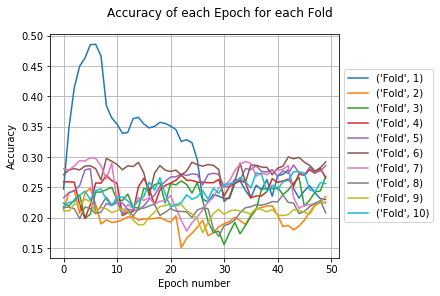

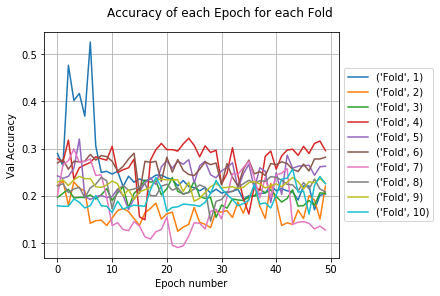

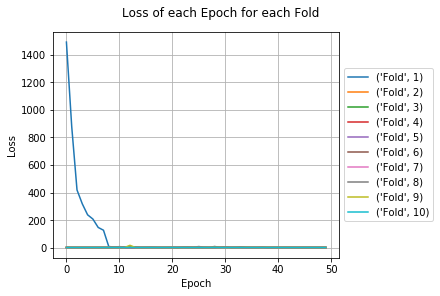

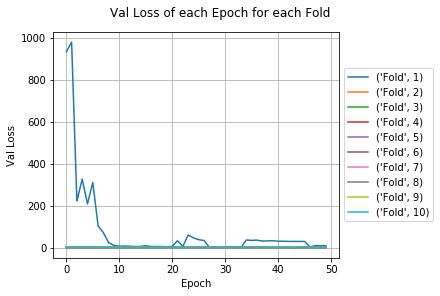

In [21]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array)

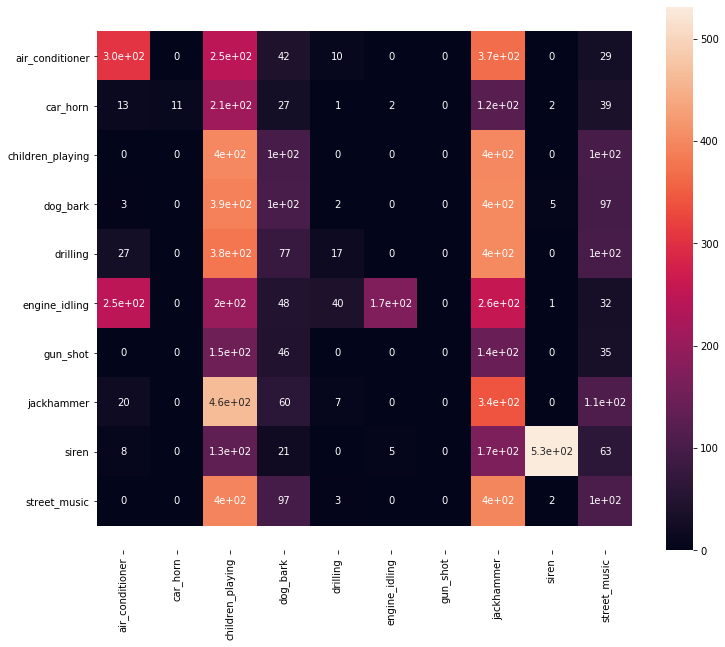

In [22]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [23]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.309986     48.5306
1    2  0.201079     44.7411
2    3  0.229307     44.7163
3    4  0.251857     45.1785
4    5  0.256988     43.8101
5    6  0.279765     45.3952
6    7  0.248328     44.3011
7    8  0.213220     46.4884
8    9  0.210753     46.1747
9   10  0.244476     45.3757

    Average Accuracy  Total Time
0          0.244576    454.7117


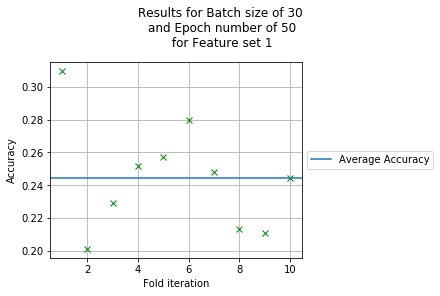

In [24]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [25]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 2.0022 - accuracy: 0.18 - ETA: 0s - loss: 1.9230 - accuracy: 0.24 - ETA: 0s - loss: 1.9135 - accuracy: 0.26 - ETA: 0s - loss: 1.9093 - accuracy: 0.26 - ETA: 0s - loss: 1.9021 - accuracy: 0.26 - ETA: 0s - loss: 1.8870 - accuracy: 0.26 - ETA: 0s - loss: 1.8937 - accuracy: 0.26 - ETA: 0s - loss: 1.8946 - accuracy: 0.26 - ETA: 0s - loss: 1.8937 - accuracy: 0.26 - ETA: 0s - loss: 1.8990 - accuracy: 0.26 - ETA: 0s - loss: 1.8979 - accuracy: 0.26 - ETA: 0s - loss: 1.8997 - accuracy: 0.25 - 1s 78us/step - loss: 1.9014 - accuracy: 0.2584 - val_loss: 2.0405 - val_accuracy: 0.2497
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 2.1426 - accuracy: 0.18 - ETA: 0s - loss: 1.9667 - accuracy: 0.25 - ETA: 0s - loss: 1.9048 - accuracy: 0.26 - ETA: 0s - loss: 1.8990 - accuracy: 0.27 - ETA: 0s - loss: 1.8844 - accuracy: 0.27 - ETA: 0s - loss: 1.8899 - accuracy: 0.2

7895/7895 [==============================] - ETA: 2s - loss: 2.0050 - accuracy: 0.21 - ETA: 1s - loss: 1.9452 - accuracy: 0.24 - ETA: 0s - loss: 1.8858 - accuracy: 0.26 - ETA: 0s - loss: 1.9127 - accuracy: 0.26 - ETA: 0s - loss: 1.9088 - accuracy: 0.26 - ETA: 0s - loss: 1.9155 - accuracy: 0.26 - ETA: 0s - loss: 1.9125 - accuracy: 0.26 - ETA: 0s - loss: 1.9192 - accuracy: 0.25 - ETA: 0s - loss: 1.9077 - accuracy: 0.26 - ETA: 0s - loss: 1.9039 - accuracy: 0.26 - ETA: 0s - loss: 1.9022 - accuracy: 0.26 - ETA: 0s - loss: 1.8954 - accuracy: 0.26 - ETA: 0s - loss: 1.9028 - accuracy: 0.26 - ETA: 0s - loss: 1.9016 - accuracy: 0.26 - ETA: 0s - loss: 1.9006 - accuracy: 0.26 - ETA: 0s - loss: 1.8995 - accuracy: 0.26 - ETA: 0s - loss: 1.9001 - accuracy: 0.26 - ETA: 0s - loss: 1.8996 - accuracy: 0.26 - ETA: 0s - loss: 1.9004 - accuracy: 0.26 - ETA: 0s - loss: 1.8958 - accuracy: 0.26 - 1s 139us/step - loss: 1.8969 - accuracy: 0.2640 - val_loss: 2.2238 - val_accuracy: 0.2449
Epoch 10/30
7895/7895 [==

7895/7895 [==============================] - ETA: 0s - loss: 2.0219 - accuracy: 0.25 - ETA: 0s - loss: 1.9996 - accuracy: 0.22 - ETA: 0s - loss: 2.0264 - accuracy: 0.21 - ETA: 0s - loss: 2.0260 - accuracy: 0.21 - ETA: 0s - loss: 2.0214 - accuracy: 0.21 - ETA: 0s - loss: 2.0106 - accuracy: 0.22 - ETA: 0s - loss: 2.0064 - accuracy: 0.22 - ETA: 0s - loss: 2.0073 - accuracy: 0.22 - ETA: 0s - loss: 2.0070 - accuracy: 0.22 - ETA: 0s - loss: 2.0078 - accuracy: 0.22 - ETA: 0s - loss: 2.0103 - accuracy: 0.22 - ETA: 0s - loss: 2.0060 - accuracy: 0.22 - ETA: 0s - loss: 2.0051 - accuracy: 0.22 - ETA: 0s - loss: 2.0003 - accuracy: 0.22 - ETA: 0s - loss: 2.0001 - accuracy: 0.22 - ETA: 0s - loss: 1.9939 - accuracy: 0.22 - 1s 110us/step - loss: 1.9918 - accuracy: 0.2260 - val_loss: 2.1237 - val_accuracy: 0.1852
Epoch 18/30
7895/7895 [==============================] - ETA: 1s - loss: 1.7841 - accuracy: 0.34 - ETA: 1s - loss: 1.9174 - accuracy: 0.23 - ETA: 1s - loss: 1.9204 - accuracy: 0.23 - ETA: 1s - 

7895/7895 [==============================] - ETA: 1s - loss: 1.9438 - accuracy: 0.28 - ETA: 0s - loss: 1.9020 - accuracy: 0.27 - ETA: 0s - loss: 1.8821 - accuracy: 0.28 - ETA: 0s - loss: 1.8874 - accuracy: 0.29 - ETA: 0s - loss: 1.8997 - accuracy: 0.27 - ETA: 0s - loss: 1.8946 - accuracy: 0.27 - ETA: 0s - loss: 1.8894 - accuracy: 0.27 - ETA: 0s - loss: 1.8887 - accuracy: 0.27 - ETA: 0s - loss: 1.8904 - accuracy: 0.27 - ETA: 0s - loss: 1.8980 - accuracy: 0.27 - ETA: 0s - loss: 1.9201 - accuracy: 0.27 - ETA: 0s - loss: 1.9243 - accuracy: 0.26 - ETA: 0s - loss: 1.9240 - accuracy: 0.26 - ETA: 0s - loss: 1.9254 - accuracy: 0.26 - ETA: 0s - loss: 1.9229 - accuracy: 0.26 - ETA: 0s - loss: 1.9228 - accuracy: 0.26 - ETA: 0s - loss: 1.9292 - accuracy: 0.25 - ETA: 0s - loss: 1.9296 - accuracy: 0.25 - ETA: 0s - loss: 1.9292 - accuracy: 0.25 - ETA: 0s - loss: 1.9276 - accuracy: 0.25 - 1s 137us/step - loss: 1.9242 - accuracy: 0.2570 - val_loss: 2.2735 - val_accuracy: 0.1912
Epoch 26/30
7895/7895 [==

## Model 2

In [26]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,8,1)))
model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)
Accuracy of Fold 1 is 0.7852398157119751
Time to train Fold 1 : 78.6054 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.845757007598877
Time to train Fold 2 : 65.391 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.8657313585281372
Time to train Fold 3 : 59.9696 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.8837653398513794
Time to train Fold 4 : 69.4418 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.9003410339355469
Time to train Fold 5 : 66.366 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823, 

In [28]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.47436018716680667, 0.5035102100618841, 0.4879725085910653, 0.4879725085910653
1, 0.6269852000351999, 0.6766402507196035, 0.6238738738738738, 0.6238738738738738
2, 0.5921409105831247, 0.6304659040548174, 0.5891891891891892, 0.5891891891891892
3, 0.6676869567489901, 0.6963612475346291, 0.6616161616161617, 0.6616161616161617
4, 0.7573373619801717, 0.7946520560688569, 0.7457264957264957, 0.7457264957264957
5, 0.734164590594919, 0.770146480610745, 0.7314702308626975, 0.7314702308626975
6, 0.8392715055447468, 0.8446601251555942, 0.8400954653937948, 0.8400954653937948
7, 0.8072572332863511, 0.8209755891549214, 0.8076923076923077, 0.8076923076923077
8, 0.8371183987030344, 0.8472390491879795, 0.8382352941176471, 0.8382352941176471
9, 0.8510812913009016, 0.8578063949629053, 0.8506571087216248, 0.8506571087216248


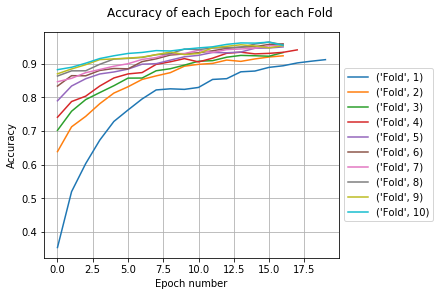

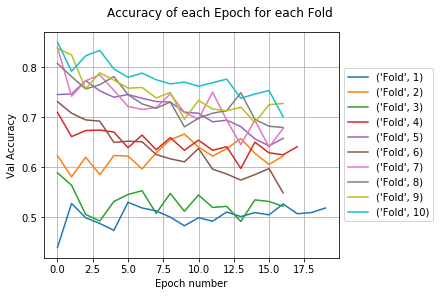

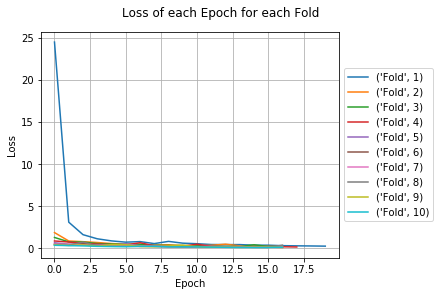

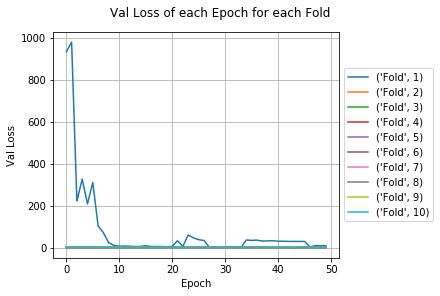

In [29]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

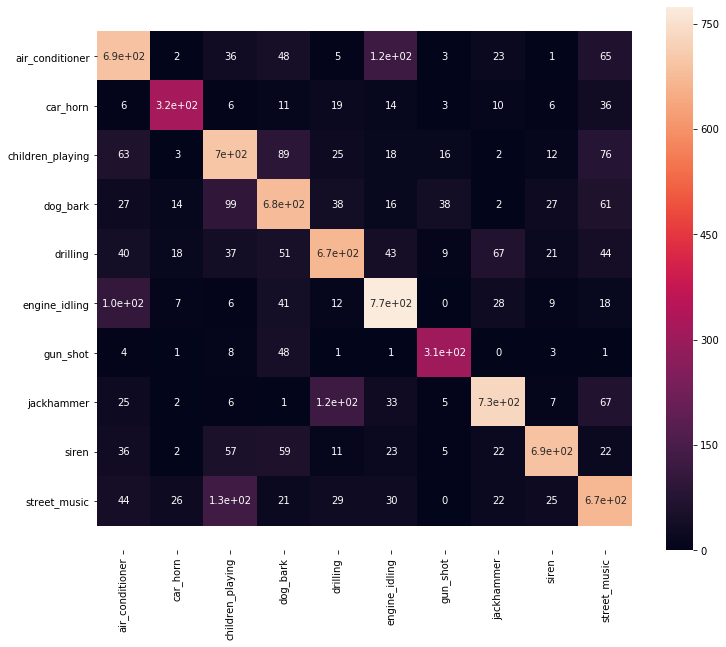

In [30]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [31]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.785240     78.6054
1    2  0.845757     65.3910
2    3  0.865731     59.9696
3    4  0.883765     69.4418
4    5  0.900341     66.3660
5    6  0.913025     65.8838
6    7  0.914932     69.1379
7    8  0.925406     69.3121
8    9  0.926025     69.3657
9   10  0.934843     70.3239

    Average Accuracy  Total Time
0          0.889507    683.7972


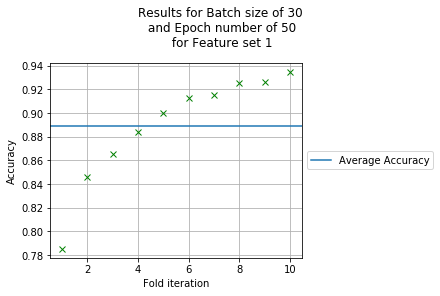

In [32]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [33]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 5s - loss: 0.4173 - accuracy: 0.78 - ETA: 6s - loss: 0.3342 - accuracy: 0.86 - ETA: 5s - loss: 0.3277 - accuracy: 0.88 - ETA: 4s - loss: 0.3136 - accuracy: 0.88 - ETA: 4s - loss: 0.3510 - accuracy: 0.87 - ETA: 4s - loss: 0.3510 - accuracy: 0.86 - ETA: 3s - loss: 0.3616 - accuracy: 0.86 - ETA: 3s - loss: 0.3441 - accuracy: 0.87 - ETA: 3s - loss: 0.3425 - accuracy: 0.87 - ETA: 3s - loss: 0.3341 - accuracy: 0.87 - ETA: 3s - loss: 0.3262 - accuracy: 0.87 - ETA: 3s - loss: 0.3231 - accuracy: 0.88 - ETA: 3s - loss: 0.3244 - accuracy: 0.88 - ETA: 3s - loss: 0.3232 - accuracy: 0.88 - ETA: 3s - loss: 0.3171 - accuracy: 0.88 - ETA: 3s - loss: 0.3184 - accuracy: 0.88 - ETA: 3s - loss: 0.3240 - accuracy: 0.88 - ETA: 3s - loss: 0.3246 - accuracy: 0.88 - ETA: 3s - loss: 0.3230 - accuracy: 0.88 - ETA: 2s - loss: 0.3257 - accuracy: 0.88 - ETA: 2s - loss: 0.3238 - accuracy: 0.88 - ETA: 2s - loss:

7895/7895 [==============================] - ETA: 3s - loss: 0.1171 - accuracy: 0.96 - ETA: 3s - loss: 0.1837 - accuracy: 0.93 - ETA: 3s - loss: 0.2780 - accuracy: 0.89 - ETA: 3s - loss: 0.2731 - accuracy: 0.90 - ETA: 3s - loss: 0.2554 - accuracy: 0.91 - ETA: 3s - loss: 0.2462 - accuracy: 0.91 - ETA: 3s - loss: 0.2419 - accuracy: 0.91 - ETA: 3s - loss: 0.2408 - accuracy: 0.91 - ETA: 3s - loss: 0.2313 - accuracy: 0.91 - ETA: 3s - loss: 0.2293 - accuracy: 0.91 - ETA: 3s - loss: 0.2304 - accuracy: 0.91 - ETA: 3s - loss: 0.2340 - accuracy: 0.91 - ETA: 2s - loss: 0.2301 - accuracy: 0.91 - ETA: 2s - loss: 0.2304 - accuracy: 0.91 - ETA: 2s - loss: 0.2324 - accuracy: 0.91 - ETA: 2s - loss: 0.2345 - accuracy: 0.91 - ETA: 2s - loss: 0.2353 - accuracy: 0.91 - ETA: 2s - loss: 0.2403 - accuracy: 0.91 - ETA: 2s - loss: 0.2384 - accuracy: 0.91 - ETA: 2s - loss: 0.2421 - accuracy: 0.91 - ETA: 2s - loss: 0.2418 - accuracy: 0.91 - ETA: 2s - loss: 0.2390 - accuracy: 0.91 - ETA: 2s - loss: 0.2380 - accura

7895/7895 [==============================] - ETA: 5s - loss: 0.1353 - accuracy: 0.96 - ETA: 4s - loss: 0.1802 - accuracy: 0.93 - ETA: 3s - loss: 0.1523 - accuracy: 0.94 - ETA: 3s - loss: 0.1750 - accuracy: 0.93 - ETA: 3s - loss: 0.1823 - accuracy: 0.93 - ETA: 3s - loss: 0.1818 - accuracy: 0.94 - ETA: 3s - loss: 0.1752 - accuracy: 0.94 - ETA: 3s - loss: 0.1696 - accuracy: 0.94 - ETA: 3s - loss: 0.1711 - accuracy: 0.94 - ETA: 3s - loss: 0.1681 - accuracy: 0.94 - ETA: 3s - loss: 0.1676 - accuracy: 0.94 - ETA: 3s - loss: 0.1677 - accuracy: 0.94 - ETA: 3s - loss: 0.1695 - accuracy: 0.94 - ETA: 3s - loss: 0.1744 - accuracy: 0.94 - ETA: 2s - loss: 0.1767 - accuracy: 0.94 - ETA: 2s - loss: 0.1762 - accuracy: 0.94 - ETA: 2s - loss: 0.1772 - accuracy: 0.94 - ETA: 2s - loss: 0.1761 - accuracy: 0.94 - ETA: 2s - loss: 0.1776 - accuracy: 0.93 - ETA: 2s - loss: 0.1821 - accuracy: 0.93 - ETA: 2s - loss: 0.1793 - accuracy: 0.93 - ETA: 2s - loss: 0.1836 - accuracy: 0.93 - ETA: 2s - loss: 0.1837 - accura

7895/7895 [==============================] - ETA: 3s - loss: 0.1463 - accuracy: 0.93 - ETA: 3s - loss: 0.1409 - accuracy: 0.93 - ETA: 3s - loss: 0.1786 - accuracy: 0.92 - ETA: 3s - loss: 0.1625 - accuracy: 0.93 - ETA: 3s - loss: 0.1701 - accuracy: 0.93 - ETA: 3s - loss: 0.1702 - accuracy: 0.93 - ETA: 3s - loss: 0.1613 - accuracy: 0.94 - ETA: 3s - loss: 0.1585 - accuracy: 0.94 - ETA: 3s - loss: 0.1593 - accuracy: 0.94 - ETA: 3s - loss: 0.1592 - accuracy: 0.94 - ETA: 3s - loss: 0.1633 - accuracy: 0.94 - ETA: 3s - loss: 0.1621 - accuracy: 0.94 - ETA: 3s - loss: 0.1569 - accuracy: 0.94 - ETA: 3s - loss: 0.1542 - accuracy: 0.94 - ETA: 3s - loss: 0.1493 - accuracy: 0.95 - ETA: 3s - loss: 0.1518 - accuracy: 0.94 - ETA: 2s - loss: 0.1496 - accuracy: 0.95 - ETA: 2s - loss: 0.1521 - accuracy: 0.94 - ETA: 2s - loss: 0.1503 - accuracy: 0.94 - ETA: 2s - loss: 0.1575 - accuracy: 0.94 - ETA: 2s - loss: 0.1551 - accuracy: 0.94 - ETA: 2s - loss: 0.1555 - accuracy: 0.94 - ETA: 2s - loss: 0.1562 - accura

7895/7895 [==============================] - ETA: 6s - loss: 0.4037 - accuracy: 0.93 - ETA: 4s - loss: 0.2430 - accuracy: 0.95 - ETA: 4s - loss: 0.1917 - accuracy: 0.95 - ETA: 4s - loss: 0.1955 - accuracy: 0.94 - ETA: 3s - loss: 0.1821 - accuracy: 0.94 - ETA: 3s - loss: 0.1803 - accuracy: 0.94 - ETA: 3s - loss: 0.1849 - accuracy: 0.94 - ETA: 3s - loss: 0.1801 - accuracy: 0.94 - ETA: 3s - loss: 0.1791 - accuracy: 0.94 - ETA: 3s - loss: 0.1799 - accuracy: 0.94 - ETA: 3s - loss: 0.1792 - accuracy: 0.94 - ETA: 3s - loss: 0.1757 - accuracy: 0.94 - ETA: 3s - loss: 0.1714 - accuracy: 0.94 - ETA: 3s - loss: 0.1738 - accuracy: 0.94 - ETA: 3s - loss: 0.1725 - accuracy: 0.94 - ETA: 3s - loss: 0.1670 - accuracy: 0.94 - ETA: 3s - loss: 0.1675 - accuracy: 0.94 - ETA: 3s - loss: 0.1654 - accuracy: 0.94 - ETA: 2s - loss: 0.1639 - accuracy: 0.94 - ETA: 2s - loss: 0.1621 - accuracy: 0.94 - ETA: 2s - loss: 0.1623 - accuracy: 0.94 - ETA: 2s - loss: 0.1624 - accuracy: 0.94 - ETA: 2s - loss: 0.1619 - accura

7895/7895 [==============================] - ETA: 2s - loss: 0.1477 - accuracy: 0.96 - ETA: 3s - loss: 0.1747 - accuracy: 0.94 - ETA: 3s - loss: 0.1707 - accuracy: 0.94 - ETA: 3s - loss: 0.1475 - accuracy: 0.95 - ETA: 3s - loss: 0.1625 - accuracy: 0.95 - ETA: 3s - loss: 0.1613 - accuracy: 0.94 - ETA: 3s - loss: 0.1734 - accuracy: 0.94 - ETA: 3s - loss: 0.1610 - accuracy: 0.95 - ETA: 3s - loss: 0.1737 - accuracy: 0.94 - ETA: 3s - loss: 0.1767 - accuracy: 0.94 - ETA: 3s - loss: 0.1754 - accuracy: 0.94 - ETA: 3s - loss: 0.1731 - accuracy: 0.94 - ETA: 3s - loss: 0.1771 - accuracy: 0.94 - ETA: 3s - loss: 0.1742 - accuracy: 0.94 - ETA: 3s - loss: 0.1727 - accuracy: 0.94 - ETA: 3s - loss: 0.1712 - accuracy: 0.94 - ETA: 2s - loss: 0.1672 - accuracy: 0.94 - ETA: 2s - loss: 0.1662 - accuracy: 0.94 - ETA: 2s - loss: 0.1645 - accuracy: 0.94 - ETA: 2s - loss: 0.1595 - accuracy: 0.94 - ETA: 2s - loss: 0.1562 - accuracy: 0.94 - ETA: 2s - loss: 0.1544 - accuracy: 0.94 - ETA: 2s - loss: 0.1574 - accura

7895/7895 [==============================] - ETA: 5s - loss: 0.1211 - accuracy: 0.96 - ETA: 4s - loss: 0.1377 - accuracy: 0.96 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1363 - accuracy: 0.95 - ETA: 3s - loss: 0.1313 - accuracy: 0.95 - ETA: 3s - loss: 0.1337 - accuracy: 0.95 - ETA: 3s - loss: 0.1409 - accuracy: 0.94 - ETA: 3s - loss: 0.1343 - accuracy: 0.95 - ETA: 3s - loss: 0.1327 - accuracy: 0.95 - ETA: 3s - loss: 0.1337 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - accuracy: 0.94 - ETA: 3s - loss: 0.1327 - accuracy: 0.94 - ETA: 3s - loss: 0.1383 - accuracy: 0.94 - ETA: 3s - loss: 0.1342 - accuracy: 0.95 - ETA: 3s - loss: 0.1335 - accuracy: 0.95 - ETA: 3s - loss: 0.1315 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - accuracy: 0.95 - ETA: 3s - loss: 0.1312 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 2s - loss: 0.1285 - accuracy: 0.95 - ETA: 2s - loss: 0.1269 - accuracy: 0.95 - ETA: 2s - loss: 0.1247 - accura

7895/7895 [==============================] - ETA: 3s - loss: 0.1005 - accuracy: 0.96 - ETA: 4s - loss: 0.0914 - accuracy: 0.96 - ETA: 4s - loss: 0.0918 - accuracy: 0.96 - ETA: 4s - loss: 0.1241 - accuracy: 0.96 - ETA: 3s - loss: 0.1132 - accuracy: 0.95 - ETA: 3s - loss: 0.1073 - accuracy: 0.96 - ETA: 3s - loss: 0.1022 - accuracy: 0.96 - ETA: 3s - loss: 0.0970 - accuracy: 0.96 - ETA: 3s - loss: 0.1035 - accuracy: 0.96 - ETA: 3s - loss: 0.1028 - accuracy: 0.96 - ETA: 3s - loss: 0.1029 - accuracy: 0.96 - ETA: 3s - loss: 0.1024 - accuracy: 0.96 - ETA: 3s - loss: 0.1000 - accuracy: 0.96 - ETA: 3s - loss: 0.1026 - accuracy: 0.96 - ETA: 3s - loss: 0.1033 - accuracy: 0.96 - ETA: 3s - loss: 0.1022 - accuracy: 0.96 - ETA: 3s - loss: 0.1009 - accuracy: 0.96 - ETA: 3s - loss: 0.1003 - accuracy: 0.96 - ETA: 2s - loss: 0.1012 - accuracy: 0.96 - ETA: 2s - loss: 0.0984 - accuracy: 0.96 - ETA: 2s - loss: 0.0964 - accuracy: 0.96 - ETA: 2s - loss: 0.0968 - accuracy: 0.96 - ETA: 2s - loss: 0.0990 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.0823 - accuracy: 1.00 - ETA: 4s - loss: 0.0758 - accuracy: 0.99 - ETA: 4s - loss: 0.0720 - accuracy: 0.98 - ETA: 4s - loss: 0.0755 - accuracy: 0.98 - ETA: 4s - loss: 0.0774 - accuracy: 0.98 - ETA: 4s - loss: 0.0722 - accuracy: 0.98 - ETA: 4s - loss: 0.0783 - accuracy: 0.98 - ETA: 3s - loss: 0.0802 - accuracy: 0.97 - ETA: 3s - loss: 0.0834 - accuracy: 0.97 - ETA: 3s - loss: 0.0808 - accuracy: 0.97 - ETA: 3s - loss: 0.0773 - accuracy: 0.98 - ETA: 3s - loss: 0.0744 - accuracy: 0.98 - ETA: 3s - loss: 0.0698 - accuracy: 0.98 - ETA: 3s - loss: 0.0677 - accuracy: 0.98 - ETA: 3s - loss: 0.0713 - accuracy: 0.98 - ETA: 3s - loss: 0.0711 - accuracy: 0.98 - ETA: 3s - loss: 0.0735 - accuracy: 0.98 - ETA: 3s - loss: 0.0721 - accuracy: 0.98 - ETA: 3s - loss: 0.0725 - accuracy: 0.98 - ETA: 3s - loss: 0.0720 - accuracy: 0.98 - ETA: 2s - loss: 0.0735 - accuracy: 0.98 - ETA: 2s - loss: 0.0710 - accuracy: 0.98 - ETA: 2s - loss: 0.0702 - accura

7895/7895 [==============================] - ETA: 3s - loss: 0.2443 - accuracy: 0.96 - ETA: 4s - loss: 0.1021 - accuracy: 0.96 - ETA: 3s - loss: 0.0764 - accuracy: 0.97 - ETA: 3s - loss: 0.0903 - accuracy: 0.97 - ETA: 3s - loss: 0.0792 - accuracy: 0.97 - ETA: 3s - loss: 0.0741 - accuracy: 0.97 - ETA: 3s - loss: 0.0694 - accuracy: 0.97 - ETA: 3s - loss: 0.0623 - accuracy: 0.97 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0602 - accuracy: 0.98 - ETA: 3s - loss: 0.0596 - accuracy: 0.98 - ETA: 3s - loss: 0.0643 - accuracy: 0.97 - ETA: 3s - loss: 0.0643 - accuracy: 0.97 - ETA: 2s - loss: 0.0657 - accuracy: 0.97 - ETA: 2s - loss: 0.0625 - accuracy: 0.97 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0594 - accuracy: 0.98 - ETA: 2s - loss: 0.0596 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0636 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accura

Epoch 22/30
7895/7895 [==============================] - ETA: 3s - loss: 0.0440 - accuracy: 1.00 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.0952 - accuracy: 0.96 - ETA: 3s - loss: 0.0839 - accuracy: 0.97 - ETA: 3s - loss: 0.1210 - accuracy: 0.97 - ETA: 3s - loss: 0.1158 - accuracy: 0.97 - ETA: 3s - loss: 0.1135 - accuracy: 0.97 - ETA: 3s - loss: 0.1187 - accuracy: 0.97 - ETA: 3s - loss: 0.1176 - accuracy: 0.97 - ETA: 3s - loss: 0.1092 - accuracy: 0.97 - ETA: 2s - loss: 0.1072 - accuracy: 0.97 - ETA: 2s - loss: 0.1023 - accuracy: 0.97 - ETA: 2s - loss: 0.1112 - accuracy: 0.97 - ETA: 2s - loss: 0.1084 - accuracy: 0.97 - ETA: 2s - loss: 0.1101 - accuracy: 0.97 - ETA: 2s - loss: 0.1048 - accuracy: 0.97 - ETA: 2s - loss: 0.1020 - accuracy: 0.97 - ETA: 2s - loss: 0.1016 - accuracy: 0.97 - ETA: 2s - loss: 0.1007 - accuracy: 0.97 - ETA: 2s - loss: 0.0975 - accuracy: 0.97 - ETA: 2s - loss: 0.1003 - accuracy: 0.97 - ETA: 2s - loss: 0.1018 - accuracy: 0.97 - ETA: 2s - loss: 0.0

7895/7895 [==============================] - ETA: 3s - loss: 0.0073 - accuracy: 1.00 - ETA: 3s - loss: 0.0458 - accuracy: 0.99 - ETA: 3s - loss: 0.0539 - accuracy: 0.98 - ETA: 3s - loss: 0.0417 - accuracy: 0.99 - ETA: 3s - loss: 0.0484 - accuracy: 0.98 - ETA: 3s - loss: 0.1820 - accuracy: 0.98 - ETA: 3s - loss: 0.1807 - accuracy: 0.98 - ETA: 3s - loss: 0.1706 - accuracy: 0.98 - ETA: 3s - loss: 0.1563 - accuracy: 0.98 - ETA: 3s - loss: 0.1434 - accuracy: 0.98 - ETA: 3s - loss: 0.1452 - accuracy: 0.97 - ETA: 3s - loss: 0.1442 - accuracy: 0.97 - ETA: 2s - loss: 0.1520 - accuracy: 0.97 - ETA: 2s - loss: 0.1517 - accuracy: 0.97 - ETA: 2s - loss: 0.1504 - accuracy: 0.97 - ETA: 2s - loss: 0.1535 - accuracy: 0.97 - ETA: 2s - loss: 0.1538 - accuracy: 0.96 - ETA: 2s - loss: 0.1713 - accuracy: 0.96 - ETA: 2s - loss: 0.1678 - accuracy: 0.96 - ETA: 2s - loss: 0.1649 - accuracy: 0.96 - ETA: 2s - loss: 0.1607 - accuracy: 0.96 - ETA: 2s - loss: 0.1637 - accuracy: 0.96 - ETA: 2s - loss: 0.1598 - accura

7895/7895 [==============================] - ETA: 2s - loss: 0.0847 - accuracy: 0.96 - ETA: 3s - loss: 0.0644 - accuracy: 0.98 - ETA: 3s - loss: 0.0572 - accuracy: 0.98 - ETA: 3s - loss: 0.0936 - accuracy: 0.97 - ETA: 3s - loss: 0.0870 - accuracy: 0.97 - ETA: 3s - loss: 0.0889 - accuracy: 0.96 - ETA: 3s - loss: 0.0796 - accuracy: 0.97 - ETA: 3s - loss: 0.0782 - accuracy: 0.97 - ETA: 3s - loss: 0.0801 - accuracy: 0.97 - ETA: 3s - loss: 0.0755 - accuracy: 0.97 - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 3s - loss: 0.0681 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0667 - accuracy: 0.98 - ETA: 3s - loss: 0.0722 - accuracy: 0.97 - ETA: 3s - loss: 0.0721 - accuracy: 0.97 - ETA: 3s - loss: 0.0737 - accuracy: 0.97 - ETA: 3s - loss: 0.0743 - accuracy: 0.97 - ETA: 3s - loss: 0.0732 - accuracy: 0.97 - ETA: 3s - loss: 0.0819 - accuracy: 0.97 - ETA: 2s - loss: 0.0818 - accuracy: 0.97 - ETA: 2s - loss: 0.0819 - accuracy: 0.97 - ETA: 2s - loss: 0.0816 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.0580 - accuracy: 1.00 - ETA: 4s - loss: 0.0629 - accuracy: 0.98 - ETA: 4s - loss: 0.0824 - accuracy: 0.97 - ETA: 4s - loss: 0.0639 - accuracy: 0.98 - ETA: 4s - loss: 0.0641 - accuracy: 0.98 - ETA: 4s - loss: 0.0623 - accuracy: 0.98 - ETA: 4s - loss: 0.0582 - accuracy: 0.98 - ETA: 4s - loss: 0.0579 - accuracy: 0.98 - ETA: 4s - loss: 0.0609 - accuracy: 0.98 - ETA: 4s - loss: 0.0664 - accuracy: 0.98 - ETA: 4s - loss: 0.0632 - accuracy: 0.98 - ETA: 4s - loss: 0.0649 - accuracy: 0.98 - ETA: 4s - loss: 0.0628 - accuracy: 0.98 - ETA: 4s - loss: 0.0605 - accuracy: 0.98 - ETA: 4s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0627 - accuracy: 0.98 - ETA: 3s - loss: 0.0611 - accuracy: 0.98 - ETA: 3s - loss: 0.0624 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0585 - accuracy: 0.98 - ETA: 3s - loss: 0.0576 - accura

837/837 [==============================] - ETA:  - ETA:  - 0s 93us/step

Accuracy of model 2 with no cross validation: 0.707


## Model 3

In [34]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [35]:
Accuracy_array_3=[]
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.11182910203933716
Time to train Fold 1 : 199.0736 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.1101376935839653
Time to train Fold 2 : 238.7326 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.11102572083473206
Time to train Fold 3 : 91.5837 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.11123310029506683
Time to train Fold 4 : 88.8173 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.11049827188253403
Time to train Fold 5 : 87.9785 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823, 32, 8, 1) (823, 10)
Accuracy of Fold 6 is 0.11686404794454575
Time to train Fold 6 : 92.1391 s

In [36]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.07529260100568855, 0.1235376188227119, 0.14776632302405499, 0.14776632302405499
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.01853396348809193, 0.010203040506070809, 0.10101010101010101, 0.10101010101010101
5, 0.020625020625020623, 0.011414274234787055, 0.10683760683760683, 0.10683760683760683
6, 0.012611602729059193, 0.006826815329035078, 0.08262454434993925, 0.08262454434993925
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.018352329796060964, 0.010098279507881584, 0.10049019607843138, 0.10049019607843138
10, 0.023602899653101916, 0.013155021132822036, 0.11469534050179211, 0.11469534050179211


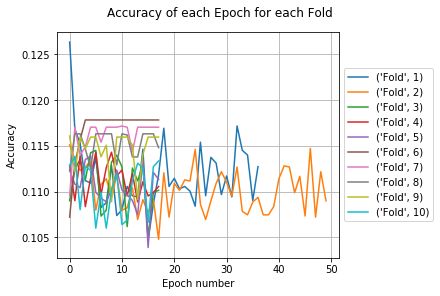

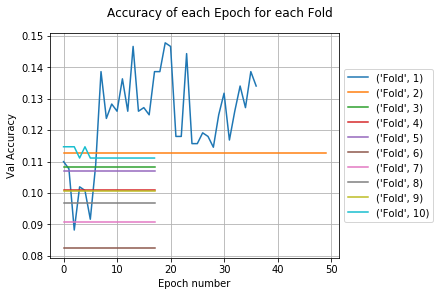

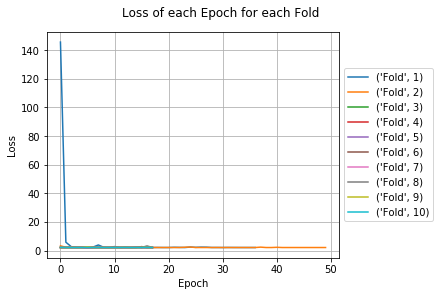

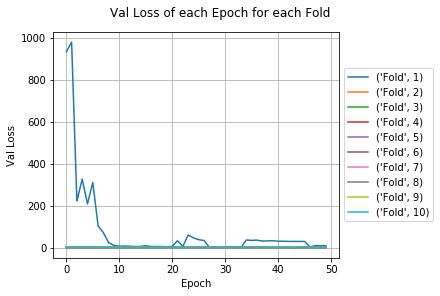

In [37]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

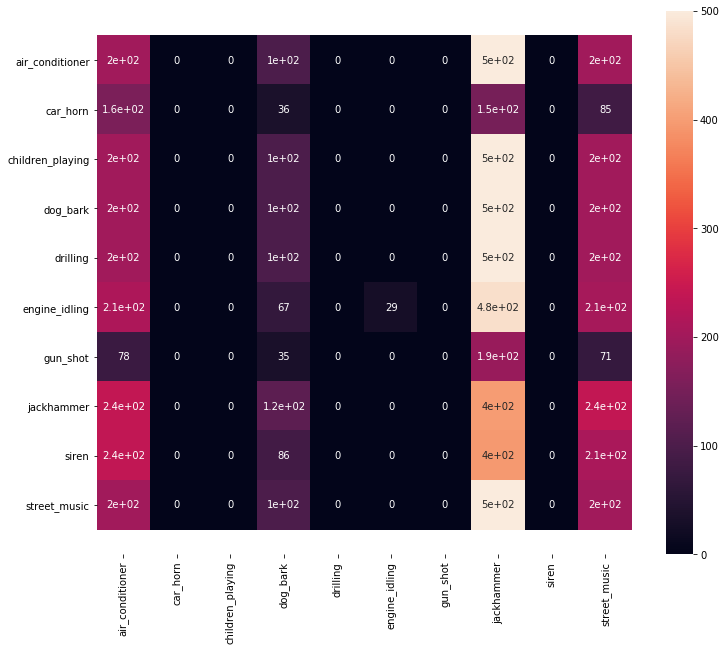

In [38]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [39]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.111829    199.0736
1    2  0.110138    238.7326
2    3  0.111026     91.5837
3    4  0.111233     88.8173
4    5  0.110498     87.9785
5    6  0.116864     92.1391
6    7  0.116115     90.3661
7    8  0.115240     84.3172
8    9  0.114599     91.6841
9   10  0.110386     88.3764

    Average Accuracy  Total Time
0          0.112793   1153.0686


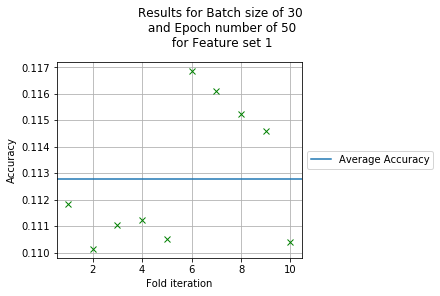

In [40]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [41]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 5s - loss: 2.3158 - accuracy: 0.15 - ETA: 5s - loss: 2.2531 - accuracy: 0.14 - ETA: 5s - loss: 2.2402 - accuracy: 0.14 - ETA: 5s - loss: 2.2497 - accuracy: 0.13 - ETA: 5s - loss: 2.2421 - accuracy: 0.12 - ETA: 5s - loss: 2.2500 - accuracy: 0.12 - ETA: 5s - loss: 2.2556 - accuracy: 0.12 - ETA: 5s - loss: 2.2680 - accuracy: 0.11 - ETA: 5s - loss: 2.2694 - accuracy: 0.11 - ETA: 5s - loss: 2.2678 - accuracy: 0.11 - ETA: 5s - loss: 2.2682 - accuracy: 0.11 - ETA: 5s - loss: 2.2688 - accuracy: 0.11 - ETA: 5s - loss: 2.2654 - accuracy: 0.10 - ETA: 5s - loss: 2.2675 - accuracy: 0.11 - ETA: 5s - loss: 2.2668 - accuracy: 0.10 - ETA: 5s - loss: 2.2668 - accuracy: 0.10 - ETA: 5s - loss: 2.2650 - accuracy: 0.11 - ETA: 4s - loss: 2.2657 - accuracy: 0.11 - ETA: 4s - loss: 2.2635 - accuracy: 0.11 - ETA: 4s - loss: 2.2647 - accuracy: 0.11 - ETA: 4s - loss: 2.2633 - accuracy: 0.11 - ETA: 4s - loss:

7895/7895 [==============================] - ETA: 5s - loss: 2.2294 - accuracy: 0.12 - ETA: 5s - loss: 2.2765 - accuracy: 0.10 - ETA: 5s - loss: 2.2811 - accuracy: 0.10 - ETA: 5s - loss: 2.2686 - accuracy: 0.12 - ETA: 5s - loss: 2.2614 - accuracy: 0.11 - ETA: 5s - loss: 2.2638 - accuracy: 0.10 - ETA: 5s - loss: 2.2581 - accuracy: 0.09 - ETA: 5s - loss: 2.2550 - accuracy: 0.10 - ETA: 5s - loss: 2.2575 - accuracy: 0.10 - ETA: 5s - loss: 2.2531 - accuracy: 0.10 - ETA: 5s - loss: 2.2521 - accuracy: 0.11 - ETA: 5s - loss: 2.2528 - accuracy: 0.10 - ETA: 5s - loss: 2.2525 - accuracy: 0.11 - ETA: 5s - loss: 2.2506 - accuracy: 0.11 - ETA: 5s - loss: 2.2526 - accuracy: 0.10 - ETA: 5s - loss: 2.2514 - accuracy: 0.10 - ETA: 5s - loss: 2.2527 - accuracy: 0.10 - ETA: 5s - loss: 2.2549 - accuracy: 0.10 - ETA: 5s - loss: 2.2521 - accuracy: 0.10 - ETA: 5s - loss: 2.2540 - accuracy: 0.10 - ETA: 4s - loss: 2.2559 - accuracy: 0.10 - ETA: 4s - loss: 2.2556 - accuracy: 0.11 - ETA: 4s - loss: 2.2559 - accura

7895/7895 [==============================] - ETA: 5s - loss: 2.2621 - accuracy: 0.12 - ETA: 5s - loss: 2.2721 - accuracy: 0.10 - ETA: 5s - loss: 2.2703 - accuracy: 0.14 - ETA: 5s - loss: 2.2694 - accuracy: 0.12 - ETA: 5s - loss: 2.2681 - accuracy: 0.12 - ETA: 5s - loss: 2.2651 - accuracy: 0.11 - ETA: 5s - loss: 2.2635 - accuracy: 0.11 - ETA: 5s - loss: 2.2584 - accuracy: 0.12 - ETA: 5s - loss: 2.2542 - accuracy: 0.12 - ETA: 5s - loss: 2.2554 - accuracy: 0.12 - ETA: 5s - loss: 2.2557 - accuracy: 0.11 - ETA: 5s - loss: 2.2579 - accuracy: 0.11 - ETA: 5s - loss: 2.2613 - accuracy: 0.11 - ETA: 5s - loss: 2.2569 - accuracy: 0.11 - ETA: 5s - loss: 2.2611 - accuracy: 0.11 - ETA: 5s - loss: 2.2594 - accuracy: 0.11 - ETA: 5s - loss: 2.2589 - accuracy: 0.11 - ETA: 4s - loss: 2.2605 - accuracy: 0.11 - ETA: 4s - loss: 2.2592 - accuracy: 0.12 - ETA: 4s - loss: 2.2572 - accuracy: 0.12 - ETA: 4s - loss: 2.2593 - accuracy: 0.12 - ETA: 4s - loss: 2.2605 - accuracy: 0.11 - ETA: 4s - loss: 2.2590 - accura

7895/7895 [==============================] - ETA: 5s - loss: 2.3178 - accuracy: 0.06 - ETA: 5s - loss: 2.2638 - accuracy: 0.12 - ETA: 5s - loss: 2.2521 - accuracy: 0.10 - ETA: 5s - loss: 2.2511 - accuracy: 0.12 - ETA: 5s - loss: 2.2599 - accuracy: 0.13 - ETA: 5s - loss: 2.2555 - accuracy: 0.13 - ETA: 5s - loss: 2.2510 - accuracy: 0.12 - ETA: 5s - loss: 2.2518 - accuracy: 0.12 - ETA: 5s - loss: 2.2546 - accuracy: 0.12 - ETA: 5s - loss: 2.2519 - accuracy: 0.13 - ETA: 5s - loss: 2.2532 - accuracy: 0.13 - ETA: 5s - loss: 2.2529 - accuracy: 0.13 - ETA: 5s - loss: 2.2551 - accuracy: 0.12 - ETA: 5s - loss: 2.2567 - accuracy: 0.12 - ETA: 5s - loss: 2.2563 - accuracy: 0.11 - ETA: 5s - loss: 2.2550 - accuracy: 0.12 - ETA: 5s - loss: 2.2515 - accuracy: 0.12 - ETA: 5s - loss: 2.2536 - accuracy: 0.12 - ETA: 5s - loss: 2.2516 - accuracy: 0.11 - ETA: 5s - loss: 2.2546 - accuracy: 0.11 - ETA: 4s - loss: 2.2537 - accuracy: 0.11 - ETA: 4s - loss: 2.2558 - accuracy: 0.12 - ETA: 4s - loss: 2.2564 - accura

7895/7895 [==============================] - ETA: 3s - loss: 2.2250 - accuracy: 0.15 - ETA: 3s - loss: 2.2581 - accuracy: 0.09 - ETA: 2s - loss: 2.2603 - accuracy: 0.09 - ETA: 2s - loss: 2.2676 - accuracy: 0.10 - ETA: 2s - loss: 2.2655 - accuracy: 0.10 - ETA: 2s - loss: 2.2622 - accuracy: 0.10 - ETA: 2s - loss: 2.2627 - accuracy: 0.10 - ETA: 2s - loss: 2.2658 - accuracy: 0.11 - ETA: 2s - loss: 2.2651 - accuracy: 0.11 - ETA: 2s - loss: 2.2599 - accuracy: 0.10 - ETA: 2s - loss: 2.2584 - accuracy: 0.11 - ETA: 2s - loss: 2.2569 - accuracy: 0.11 - ETA: 2s - loss: 2.2583 - accuracy: 0.11 - ETA: 2s - loss: 2.2591 - accuracy: 0.11 - ETA: 2s - loss: 2.2595 - accuracy: 0.11 - ETA: 2s - loss: 2.2587 - accuracy: 0.11 - ETA: 2s - loss: 2.2587 - accuracy: 0.11 - ETA: 2s - loss: 2.2585 - accuracy: 0.11 - ETA: 2s - loss: 2.2590 - accuracy: 0.10 - ETA: 1s - loss: 2.2593 - accuracy: 0.10 - ETA: 1s - loss: 2.2602 - accuracy: 0.10 - ETA: 1s - loss: 2.2601 - accuracy: 0.10 - ETA: 1s - loss: 2.2617 - accura

7895/7895 [==============================] - ETA: 4s - loss: 2.2612 - accuracy: 0.15 - ETA: 4s - loss: 2.2656 - accuracy: 0.09 - ETA: 4s - loss: 2.2619 - accuracy: 0.09 - ETA: 4s - loss: 2.2570 - accuracy: 0.08 - ETA: 4s - loss: 2.2565 - accuracy: 0.10 - ETA: 4s - loss: 2.2506 - accuracy: 0.09 - ETA: 4s - loss: 2.2463 - accuracy: 0.09 - ETA: 4s - loss: 2.2468 - accuracy: 0.10 - ETA: 4s - loss: 2.2579 - accuracy: 0.10 - ETA: 4s - loss: 2.2568 - accuracy: 0.11 - ETA: 4s - loss: 2.2562 - accuracy: 0.11 - ETA: 4s - loss: 2.2541 - accuracy: 0.10 - ETA: 4s - loss: 2.2540 - accuracy: 0.10 - ETA: 4s - loss: 2.2523 - accuracy: 0.10 - ETA: 4s - loss: 2.2518 - accuracy: 0.10 - ETA: 4s - loss: 2.2528 - accuracy: 0.10 - ETA: 4s - loss: 2.2513 - accuracy: 0.10 - ETA: 4s - loss: 2.2542 - accuracy: 0.10 - ETA: 3s - loss: 2.2542 - accuracy: 0.10 - ETA: 3s - loss: 2.2544 - accuracy: 0.10 - ETA: 3s - loss: 2.2547 - accuracy: 0.10 - ETA: 3s - loss: 2.2554 - accuracy: 0.10 - ETA: 3s - loss: 2.2535 - accura

Epoch 12/30
7895/7895 [==============================] - ETA: 6s - loss: 2.2881 - accuracy: 0.06 - ETA: 6s - loss: 2.2699 - accuracy: 0.08 - ETA: 6s - loss: 2.2611 - accuracy: 0.08 - ETA: 6s - loss: 2.2719 - accuracy: 0.11 - ETA: 6s - loss: 2.2694 - accuracy: 0.11 - ETA: 6s - loss: 2.2643 - accuracy: 0.11 - ETA: 6s - loss: 2.2685 - accuracy: 0.11 - ETA: 5s - loss: 2.2664 - accuracy: 0.10 - ETA: 5s - loss: 2.2618 - accuracy: 0.10 - ETA: 5s - loss: 2.2605 - accuracy: 0.10 - ETA: 5s - loss: 2.2610 - accuracy: 0.09 - ETA: 5s - loss: 2.2648 - accuracy: 0.10 - ETA: 5s - loss: 2.2638 - accuracy: 0.10 - ETA: 5s - loss: 2.2619 - accuracy: 0.10 - ETA: 5s - loss: 2.2609 - accuracy: 0.10 - ETA: 5s - loss: 2.2617 - accuracy: 0.10 - ETA: 5s - loss: 2.2627 - accuracy: 0.10 - ETA: 5s - loss: 2.2610 - accuracy: 0.10 - ETA: 5s - loss: 2.2609 - accuracy: 0.10 - ETA: 5s - loss: 2.2624 - accuracy: 0.10 - ETA: 5s - loss: 2.2678 - accuracy: 0.10 - ETA: 5s - loss: 2.2658 - accuracy: 0.10 - ETA: 5s - loss: 2.2

7895/7895 [==============================] - ETA: 6s - loss: 2.2852 - accuracy: 0.06 - ETA: 6s - loss: 2.2969 - accuracy: 0.11 - ETA: 6s - loss: 2.2925 - accuracy: 0.10 - ETA: 6s - loss: 2.3045 - accuracy: 0.10 - ETA: 6s - loss: 2.2941 - accuracy: 0.11 - ETA: 6s - loss: 2.2877 - accuracy: 0.11 - ETA: 6s - loss: 2.2896 - accuracy: 0.11 - ETA: 6s - loss: 2.2827 - accuracy: 0.11 - ETA: 6s - loss: 2.2812 - accuracy: 0.10 - ETA: 6s - loss: 2.2765 - accuracy: 0.10 - ETA: 6s - loss: 2.2734 - accuracy: 0.11 - ETA: 5s - loss: 2.2730 - accuracy: 0.10 - ETA: 5s - loss: 2.2719 - accuracy: 0.11 - ETA: 5s - loss: 2.2699 - accuracy: 0.11 - ETA: 5s - loss: 2.2683 - accuracy: 0.10 - ETA: 5s - loss: 2.2687 - accuracy: 0.11 - ETA: 5s - loss: 2.2699 - accuracy: 0.11 - ETA: 5s - loss: 2.2667 - accuracy: 0.11 - ETA: 5s - loss: 2.2648 - accuracy: 0.11 - ETA: 5s - loss: 2.2659 - accuracy: 0.11 - ETA: 5s - loss: 2.2632 - accuracy: 0.11 - ETA: 5s - loss: 2.2650 - accuracy: 0.11 - ETA: 5s - loss: 2.2627 - accura

7895/7895 [==============================] - ETA: 3s - loss: 2.2621 - accuracy: 0.12 - ETA: 3s - loss: 2.2646 - accuracy: 0.13 - ETA: 3s - loss: 2.2566 - accuracy: 0.12 - ETA: 2s - loss: 2.2574 - accuracy: 0.12 - ETA: 3s - loss: 2.2529 - accuracy: 0.12 - ETA: 3s - loss: 2.2515 - accuracy: 0.11 - ETA: 3s - loss: 2.2526 - accuracy: 0.11 - ETA: 3s - loss: 2.2538 - accuracy: 0.11 - ETA: 3s - loss: 2.2522 - accuracy: 0.11 - ETA: 3s - loss: 2.2490 - accuracy: 0.11 - ETA: 3s - loss: 2.2533 - accuracy: 0.11 - ETA: 3s - loss: 2.2560 - accuracy: 0.10 - ETA: 3s - loss: 2.2553 - accuracy: 0.10 - ETA: 3s - loss: 2.2587 - accuracy: 0.10 - ETA: 3s - loss: 2.2581 - accuracy: 0.10 - ETA: 3s - loss: 2.2615 - accuracy: 0.10 - ETA: 3s - loss: 2.2602 - accuracy: 0.10 - ETA: 3s - loss: 2.2609 - accuracy: 0.10 - ETA: 3s - loss: 2.2619 - accuracy: 0.10 - ETA: 3s - loss: 2.2614 - accuracy: 0.11 - ETA: 3s - loss: 2.2608 - accuracy: 0.11 - ETA: 3s - loss: 2.2595 - accuracy: 0.11 - ETA: 3s - loss: 2.2597 - accura

7895/7895 [==============================] - ETA: 5s - loss: 2.2094 - accuracy: 0.06 - ETA: 6s - loss: 2.2459 - accuracy: 0.07 - ETA: 6s - loss: 2.2684 - accuracy: 0.07 - ETA: 6s - loss: 2.2692 - accuracy: 0.10 - ETA: 6s - loss: 2.2518 - accuracy: 0.11 - ETA: 6s - loss: 2.2478 - accuracy: 0.11 - ETA: 6s - loss: 2.2478 - accuracy: 0.12 - ETA: 5s - loss: 2.2437 - accuracy: 0.12 - ETA: 5s - loss: 2.2482 - accuracy: 0.11 - ETA: 5s - loss: 2.2489 - accuracy: 0.12 - ETA: 5s - loss: 2.2501 - accuracy: 0.12 - ETA: 5s - loss: 2.2486 - accuracy: 0.12 - ETA: 5s - loss: 2.2507 - accuracy: 0.12 - ETA: 5s - loss: 2.2492 - accuracy: 0.11 - ETA: 5s - loss: 2.2513 - accuracy: 0.12 - ETA: 5s - loss: 2.2537 - accuracy: 0.12 - ETA: 5s - loss: 2.2513 - accuracy: 0.11 - ETA: 5s - loss: 2.2503 - accuracy: 0.11 - ETA: 5s - loss: 2.2501 - accuracy: 0.11 - ETA: 5s - loss: 2.2485 - accuracy: 0.11 - ETA: 5s - loss: 2.2494 - accuracy: 0.11 - ETA: 4s - loss: 2.2522 - accuracy: 0.11 - ETA: 4s - loss: 2.2519 - accura

7895/7895 [==============================] - ETA: 5s - loss: 2.2347 - accuracy: 0.09 - ETA: 6s - loss: 2.2452 - accuracy: 0.11 - ETA: 6s - loss: 2.2712 - accuracy: 0.11 - ETA: 6s - loss: 2.2680 - accuracy: 0.10 - ETA: 6s - loss: 2.2688 - accuracy: 0.10 - ETA: 6s - loss: 2.2620 - accuracy: 0.11 - ETA: 6s - loss: 2.2561 - accuracy: 0.12 - ETA: 6s - loss: 2.2640 - accuracy: 0.12 - ETA: 6s - loss: 2.2596 - accuracy: 0.11 - ETA: 5s - loss: 2.2559 - accuracy: 0.12 - ETA: 5s - loss: 2.2630 - accuracy: 0.12 - ETA: 5s - loss: 2.2696 - accuracy: 0.12 - ETA: 5s - loss: 2.2673 - accuracy: 0.12 - ETA: 5s - loss: 2.2655 - accuracy: 0.12 - ETA: 5s - loss: 2.2637 - accuracy: 0.12 - ETA: 5s - loss: 2.2637 - accuracy: 0.11 - ETA: 5s - loss: 2.2635 - accuracy: 0.12 - ETA: 5s - loss: 2.2661 - accuracy: 0.12 - ETA: 5s - loss: 2.2675 - accuracy: 0.12 - ETA: 4s - loss: 2.2648 - accuracy: 0.11 - ETA: 4s - loss: 2.2634 - accuracy: 0.11 - ETA: 4s - loss: 2.2633 - accuracy: 0.11 - ETA: 4s - loss: 2.2633 - accura

7895/7895 [==============================] - ETA: 6s - loss: 2.2558 - accuracy: 0.15 - ETA: 6s - loss: 2.2312 - accuracy: 0.12 - ETA: 6s - loss: 2.2367 - accuracy: 0.14 - ETA: 6s - loss: 2.2433 - accuracy: 0.13 - ETA: 6s - loss: 2.2440 - accuracy: 0.11 - ETA: 5s - loss: 2.2522 - accuracy: 0.12 - ETA: 5s - loss: 2.2517 - accuracy: 0.12 - ETA: 5s - loss: 2.2607 - accuracy: 0.12 - ETA: 5s - loss: 2.2637 - accuracy: 0.11 - ETA: 5s - loss: 2.2719 - accuracy: 0.12 - ETA: 5s - loss: 2.2687 - accuracy: 0.11 - ETA: 5s - loss: 2.2630 - accuracy: 0.12 - ETA: 5s - loss: 2.2630 - accuracy: 0.12 - ETA: 5s - loss: 2.2602 - accuracy: 0.12 - ETA: 5s - loss: 2.2576 - accuracy: 0.12 - ETA: 5s - loss: 2.2613 - accuracy: 0.12 - ETA: 5s - loss: 2.2642 - accuracy: 0.12 - ETA: 5s - loss: 2.2643 - accuracy: 0.12 - ETA: 5s - loss: 2.2624 - accuracy: 0.11 - ETA: 5s - loss: 2.2604 - accuracy: 0.11 - ETA: 5s - loss: 2.2610 - accuracy: 0.12 - ETA: 5s - loss: 2.2608 - accuracy: 0.12 - ETA: 5s - loss: 2.2630 - accura

7895/7895 [==============================] - ETA: 6s - loss: 2.4043 - accuracy: 0.12 - ETA: 6s - loss: 2.3256 - accuracy: 0.06 - ETA: 6s - loss: 2.2808 - accuracy: 0.08 - ETA: 6s - loss: 2.2584 - accuracy: 0.07 - ETA: 6s - loss: 2.2668 - accuracy: 0.10 - ETA: 6s - loss: 2.2650 - accuracy: 0.11 - ETA: 6s - loss: 2.2632 - accuracy: 0.11 - ETA: 6s - loss: 2.2611 - accuracy: 0.11 - ETA: 6s - loss: 2.2580 - accuracy: 0.11 - ETA: 5s - loss: 2.2580 - accuracy: 0.12 - ETA: 5s - loss: 2.2570 - accuracy: 0.13 - ETA: 5s - loss: 2.2579 - accuracy: 0.13 - ETA: 5s - loss: 2.2561 - accuracy: 0.12 - ETA: 5s - loss: 2.2613 - accuracy: 0.12 - ETA: 5s - loss: 2.2606 - accuracy: 0.11 - ETA: 5s - loss: 2.2572 - accuracy: 0.11 - ETA: 4s - loss: 2.2568 - accuracy: 0.11 - ETA: 4s - loss: 2.2607 - accuracy: 0.11 - ETA: 4s - loss: 2.2607 - accuracy: 0.11 - ETA: 4s - loss: 2.2596 - accuracy: 0.11 - ETA: 4s - loss: 2.2580 - accuracy: 0.10 - ETA: 4s - loss: 2.2569 - accuracy: 0.11 - ETA: 4s - loss: 2.2569 - accura

7895/7895 [==============================] - ETA: 5s - loss: 2.3343 - accuracy: 0.09 - ETA: 6s - loss: 2.3007 - accuracy: 0.13 - ETA: 6s - loss: 2.2863 - accuracy: 0.15 - ETA: 6s - loss: 2.2739 - accuracy: 0.12 - ETA: 6s - loss: 2.2707 - accuracy: 0.11 - ETA: 6s - loss: 2.2693 - accuracy: 0.11 - ETA: 5s - loss: 2.2668 - accuracy: 0.11 - ETA: 5s - loss: 2.2731 - accuracy: 0.10 - ETA: 5s - loss: 2.2721 - accuracy: 0.10 - ETA: 5s - loss: 2.2737 - accuracy: 0.10 - ETA: 5s - loss: 2.2726 - accuracy: 0.10 - ETA: 5s - loss: 2.2734 - accuracy: 0.10 - ETA: 5s - loss: 2.2761 - accuracy: 0.10 - ETA: 5s - loss: 2.2734 - accuracy: 0.10 - ETA: 5s - loss: 2.2702 - accuracy: 0.09 - ETA: 5s - loss: 2.2693 - accuracy: 0.10 - ETA: 5s - loss: 2.2674 - accuracy: 0.10 - ETA: 5s - loss: 2.2662 - accuracy: 0.10 - ETA: 5s - loss: 2.2623 - accuracy: 0.11 - ETA: 4s - loss: 2.2621 - accuracy: 0.11 - ETA: 4s - loss: 2.2597 - accuracy: 0.11 - ETA: 4s - loss: 2.2608 - accuracy: 0.11 - ETA: 3s - loss: 2.2613 - accura

7895/7895 [==============================] - ETA: 5s - loss: 2.2072 - accuracy: 0.12 - ETA: 5s - loss: 2.2144 - accuracy: 0.10 - ETA: 6s - loss: 2.2337 - accuracy: 0.10 - ETA: 6s - loss: 2.2512 - accuracy: 0.11 - ETA: 5s - loss: 2.2614 - accuracy: 0.12 - ETA: 5s - loss: 2.2596 - accuracy: 0.12 - ETA: 5s - loss: 2.2574 - accuracy: 0.13 - ETA: 5s - loss: 2.2523 - accuracy: 0.14 - ETA: 5s - loss: 2.2504 - accuracy: 0.13 - ETA: 5s - loss: 2.2514 - accuracy: 0.13 - ETA: 5s - loss: 2.2512 - accuracy: 0.13 - ETA: 5s - loss: 2.2519 - accuracy: 0.13 - ETA: 5s - loss: 2.2525 - accuracy: 0.12 - ETA: 5s - loss: 2.2523 - accuracy: 0.12 - ETA: 5s - loss: 2.2517 - accuracy: 0.12 - ETA: 5s - loss: 2.2547 - accuracy: 0.12 - ETA: 5s - loss: 2.2519 - accuracy: 0.12 - ETA: 5s - loss: 2.2549 - accuracy: 0.12 - ETA: 5s - loss: 2.2558 - accuracy: 0.12 - ETA: 5s - loss: 2.2568 - accuracy: 0.12 - ETA: 5s - loss: 2.2576 - accuracy: 0.12 - ETA: 5s - loss: 2.2565 - accuracy: 0.12 - ETA: 5s - loss: 2.2562 - accura

7895/7895 [==============================] - ETA: 6s - loss: 2.2053 - accuracy: 0.15 - ETA: 6s - loss: 2.2055 - accuracy: 0.15 - ETA: 6s - loss: 2.2090 - accuracy: 0.14 - ETA: 6s - loss: 2.2308 - accuracy: 0.12 - ETA: 6s - loss: 2.2270 - accuracy: 0.12 - ETA: 6s - loss: 2.2439 - accuracy: 0.11 - ETA: 6s - loss: 2.2450 - accuracy: 0.11 - ETA: 6s - loss: 2.2518 - accuracy: 0.11 - ETA: 6s - loss: 2.2580 - accuracy: 0.12 - ETA: 6s - loss: 2.2571 - accuracy: 0.12 - ETA: 6s - loss: 2.2571 - accuracy: 0.12 - ETA: 5s - loss: 2.2606 - accuracy: 0.11 - ETA: 5s - loss: 2.2595 - accuracy: 0.11 - ETA: 5s - loss: 2.2594 - accuracy: 0.12 - ETA: 5s - loss: 2.2596 - accuracy: 0.12 - ETA: 5s - loss: 2.2583 - accuracy: 0.12 - ETA: 5s - loss: 2.2590 - accuracy: 0.12 - ETA: 5s - loss: 2.2595 - accuracy: 0.12 - ETA: 5s - loss: 2.2597 - accuracy: 0.12 - ETA: 5s - loss: 2.2647 - accuracy: 0.11 - ETA: 5s - loss: 2.2641 - accuracy: 0.11 - ETA: 5s - loss: 2.2655 - accuracy: 0.11 - ETA: 5s - loss: 2.2691 - accura

7895/7895 [==============================] - ETA: 2s - loss: 2.1752 - accuracy: 0.18 - ETA: 3s - loss: 2.2242 - accuracy: 0.15 - ETA: 4s - loss: 2.2337 - accuracy: 0.15 - ETA: 4s - loss: 2.2519 - accuracy: 0.13 - ETA: 3s - loss: 2.2556 - accuracy: 0.13 - ETA: 3s - loss: 2.2633 - accuracy: 0.12 - ETA: 3s - loss: 2.2551 - accuracy: 0.12 - ETA: 3s - loss: 2.2561 - accuracy: 0.12 - ETA: 2s - loss: 2.2574 - accuracy: 0.11 - ETA: 2s - loss: 2.2531 - accuracy: 0.11 - ETA: 2s - loss: 2.2531 - accuracy: 0.11 - ETA: 2s - loss: 2.2524 - accuracy: 0.11 - ETA: 2s - loss: 2.2532 - accuracy: 0.11 - ETA: 2s - loss: 2.2533 - accuracy: 0.12 - ETA: 2s - loss: 2.2525 - accuracy: 0.11 - ETA: 2s - loss: 2.2551 - accuracy: 0.11 - ETA: 2s - loss: 2.2548 - accuracy: 0.11 - ETA: 2s - loss: 2.2537 - accuracy: 0.12 - ETA: 2s - loss: 2.2516 - accuracy: 0.12 - ETA: 3s - loss: 2.2511 - accuracy: 0.12 - ETA: 3s - loss: 2.2516 - accuracy: 0.12 - ETA: 3s - loss: 2.2514 - accuracy: 0.12 - ETA: 2s - loss: 2.2530 - accura

7895/7895 [==============================] - ETA: 5s - loss: 2.2618 - accuracy: 0.15 - ETA: 6s - loss: 2.2948 - accuracy: 0.13 - ETA: 6s - loss: 2.2845 - accuracy: 0.13 - ETA: 6s - loss: 2.2726 - accuracy: 0.12 - ETA: 6s - loss: 2.2640 - accuracy: 0.12 - ETA: 6s - loss: 2.2644 - accuracy: 0.11 - ETA: 6s - loss: 2.2592 - accuracy: 0.11 - ETA: 6s - loss: 2.2555 - accuracy: 0.11 - ETA: 6s - loss: 2.2593 - accuracy: 0.10 - ETA: 6s - loss: 2.2595 - accuracy: 0.11 - ETA: 5s - loss: 2.2591 - accuracy: 0.11 - ETA: 5s - loss: 2.2628 - accuracy: 0.11 - ETA: 5s - loss: 2.2633 - accuracy: 0.11 - ETA: 5s - loss: 2.2628 - accuracy: 0.11 - ETA: 5s - loss: 2.2601 - accuracy: 0.11 - ETA: 5s - loss: 2.2594 - accuracy: 0.10 - ETA: 5s - loss: 2.2586 - accuracy: 0.10 - ETA: 5s - loss: 2.2593 - accuracy: 0.10 - ETA: 5s - loss: 2.2602 - accuracy: 0.11 - ETA: 5s - loss: 2.2601 - accuracy: 0.10 - ETA: 5s - loss: 2.2598 - accuracy: 0.11 - ETA: 5s - loss: 2.2616 - accuracy: 0.11 - ETA: 5s - loss: 2.2637 - accura

7895/7895 [==============================] - ETA: 6s - loss: 2.2221 - accuracy: 0.18 - ETA: 6s - loss: 2.2753 - accuracy: 0.12 - ETA: 6s - loss: 2.2829 - accuracy: 0.12 - ETA: 6s - loss: 2.2836 - accuracy: 0.12 - ETA: 6s - loss: 2.2778 - accuracy: 0.12 - ETA: 6s - loss: 2.2751 - accuracy: 0.12 - ETA: 5s - loss: 2.2697 - accuracy: 0.11 - ETA: 5s - loss: 2.2647 - accuracy: 0.11 - ETA: 5s - loss: 2.2674 - accuracy: 0.11 - ETA: 5s - loss: 2.2652 - accuracy: 0.11 - ETA: 5s - loss: 2.2658 - accuracy: 0.11 - ETA: 5s - loss: 2.2641 - accuracy: 0.11 - ETA: 5s - loss: 2.2624 - accuracy: 0.11 - ETA: 5s - loss: 2.2639 - accuracy: 0.11 - ETA: 5s - loss: 2.2655 - accuracy: 0.10 - ETA: 5s - loss: 2.2642 - accuracy: 0.11 - ETA: 5s - loss: 2.2643 - accuracy: 0.10 - ETA: 5s - loss: 2.2626 - accuracy: 0.11 - ETA: 5s - loss: 2.2596 - accuracy: 0.11 - ETA: 5s - loss: 2.2582 - accuracy: 0.11 - ETA: 5s - loss: 2.2589 - accuracy: 0.11 - ETA: 5s - loss: 2.2580 - accuracy: 0.11 - ETA: 5s - loss: 2.2600 - accura

Epoch 26/30
7895/7895 [==============================] - ETA: 5s - loss: 2.2638 - accuracy: 0.18 - ETA: 6s - loss: 2.2329 - accuracy: 0.13 - ETA: 6s - loss: 2.2330 - accuracy: 0.11 - ETA: 6s - loss: 2.2283 - accuracy: 0.12 - ETA: 6s - loss: 2.2388 - accuracy: 0.13 - ETA: 6s - loss: 2.2358 - accuracy: 0.14 - ETA: 6s - loss: 2.2374 - accuracy: 0.13 - ETA: 6s - loss: 2.2460 - accuracy: 0.12 - ETA: 6s - loss: 2.2446 - accuracy: 0.12 - ETA: 6s - loss: 2.2482 - accuracy: 0.12 - ETA: 5s - loss: 2.2466 - accuracy: 0.12 - ETA: 5s - loss: 2.2487 - accuracy: 0.11 - ETA: 5s - loss: 2.2446 - accuracy: 0.11 - ETA: 5s - loss: 2.2476 - accuracy: 0.11 - ETA: 4s - loss: 2.2497 - accuracy: 0.11 - ETA: 4s - loss: 2.2496 - accuracy: 0.11 - ETA: 4s - loss: 2.2496 - accuracy: 0.12 - ETA: 4s - loss: 2.2491 - accuracy: 0.11 - ETA: 4s - loss: 2.2495 - accuracy: 0.11 - ETA: 4s - loss: 2.2505 - accuracy: 0.12 - ETA: 4s - loss: 2.2554 - accuracy: 0.12 - ETA: 4s - loss: 2.2541 - accuracy: 0.12 - ETA: 4s - loss: 2.2

7895/7895 [==============================] - ETA: 5s - loss: 2.2354 - accuracy: 0.15 - ETA: 6s - loss: 2.2968 - accuracy: 0.08 - ETA: 6s - loss: 2.2640 - accuracy: 0.08 - ETA: 6s - loss: 2.2723 - accuracy: 0.08 - ETA: 6s - loss: 2.2653 - accuracy: 0.10 - ETA: 6s - loss: 2.2564 - accuracy: 0.10 - ETA: 5s - loss: 2.2539 - accuracy: 0.09 - ETA: 5s - loss: 2.2478 - accuracy: 0.09 - ETA: 4s - loss: 2.2484 - accuracy: 0.10 - ETA: 4s - loss: 2.2469 - accuracy: 0.10 - ETA: 4s - loss: 2.2520 - accuracy: 0.09 - ETA: 4s - loss: 2.2555 - accuracy: 0.10 - ETA: 4s - loss: 2.2565 - accuracy: 0.09 - ETA: 4s - loss: 2.2576 - accuracy: 0.09 - ETA: 4s - loss: 2.2572 - accuracy: 0.10 - ETA: 4s - loss: 2.2573 - accuracy: 0.10 - ETA: 4s - loss: 2.2618 - accuracy: 0.10 - ETA: 4s - loss: 2.2596 - accuracy: 0.10 - ETA: 4s - loss: 2.2635 - accuracy: 0.10 - ETA: 4s - loss: 2.2641 - accuracy: 0.10 - ETA: 4s - loss: 2.2619 - accuracy: 0.10 - ETA: 4s - loss: 2.2617 - accuracy: 0.10 - ETA: 4s - loss: 2.2606 - accura

837/837 [==============================] - ETA:  - ETA:  - ETA:  - 0s 173us/step

Accuracy of model 3 with no cross validation: 0.111


## Model 4

In [42]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [43]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)
Accuracy of Fold 1 is 0.725351870059967
Time to train Fold 1 : 187.1809 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.846537172794342
Time to train Fold 2 : 76.0007 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.8530064821243286
Time to train Fold 3 : 70.753 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.8616704344749451
Time to train Fold 4 : 66.4435 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.8597071766853333
Time to train Fold 5 : 63.3716 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823,

In [44]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.49824075196235856, 0.5766238044629932, 0.5246277205040092, 0.5246277205040092
2, 0.7817628369451569, 0.8002971618852226, 0.7826576576576577, 0.7826576576576577
3, 0.7562511292577466, 0.777824402154272, 0.7578378378378379, 0.7578378378378379
4, 0.8390270148187899, 0.8483138384708668, 0.8404040404040404, 0.8404040404040404
5, 0.8278186736901367, 0.8393691809224098, 0.8290598290598291, 0.8290598290598291
6, 0.7636715432253439, 0.7759158137831785, 0.764277035236938, 0.764277035236938
7, 0.8308701442829863, 0.853852473126879, 0.8281622911694511, 0.8281622911694511
8, 0.7330225810147579, 0.7920133238538484, 0.7667493796526055, 0.7667493796526055
9, 0.8557195637419754, 0.8682324534308496, 0.8578431372549019, 0.8578431372549019
10, 0.8523785066692372, 0.8590152099917548, 0.8542413381123058, 0.8542413381123058


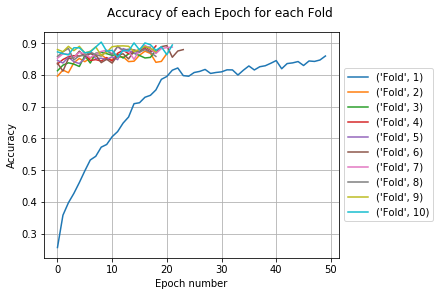

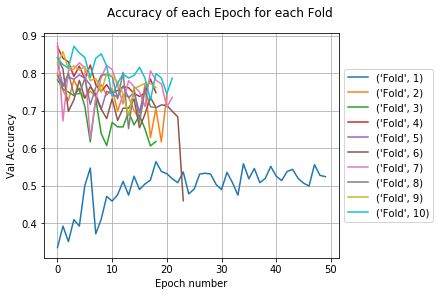

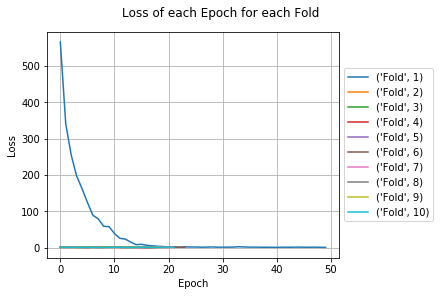

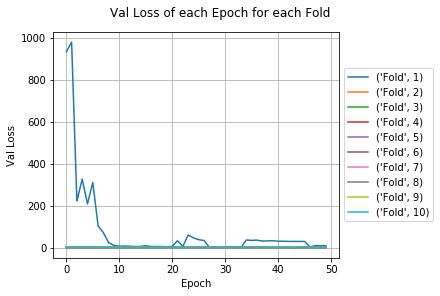

In [45]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

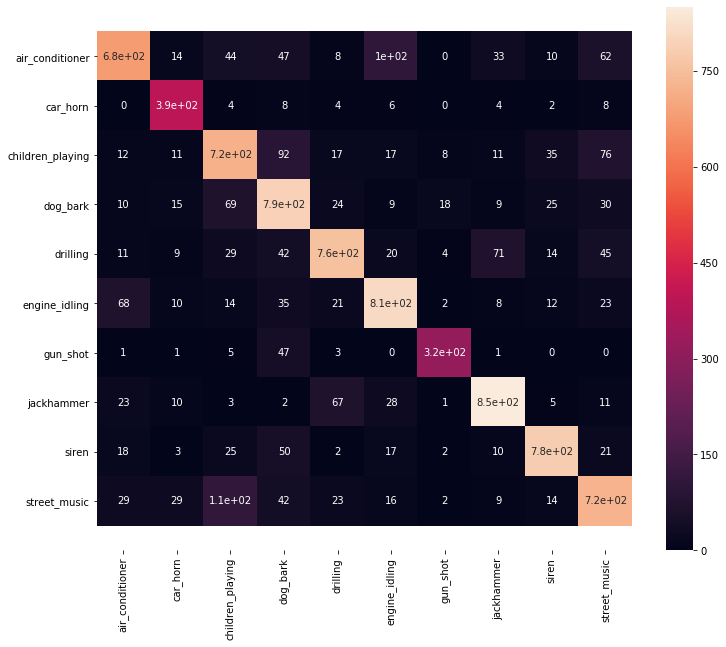

In [46]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [47]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.725352    187.1809
1    2  0.846537     76.0007
2    3  0.853006     70.7530
3    4  0.861670     66.4435
4    5  0.859707     63.3716
5    6  0.862388     85.5008
6    7  0.871853     75.4449
7    8  0.869809     66.7529
8    9  0.880814     66.4507
9   10  0.880241     73.6595

    Average Accuracy  Total Time
0          0.851138    831.5585


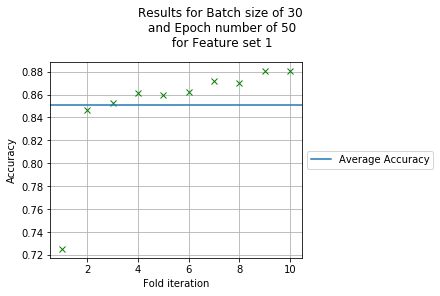

In [48]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [49]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 2s - loss: 0.4109 - accuracy: 0.84 - ETA: 2s - loss: 0.6366 - accuracy: 0.85 - ETA: 2s - loss: 0.5717 - accuracy: 0.87 - ETA: 2s - loss: 0.4817 - accuracy: 0.89 - ETA: 2s - loss: 0.4460 - accuracy: 0.89 - ETA: 2s - loss: 0.4153 - accuracy: 0.90 - ETA: 2s - loss: 0.3861 - accuracy: 0.90 - ETA: 2s - loss: 0.3835 - accuracy: 0.90 - ETA: 2s - loss: 0.3647 - accuracy: 0.90 - ETA: 2s - loss: 0.3484 - accuracy: 0.90 - ETA: 2s - loss: 0.3415 - accuracy: 0.90 - ETA: 2s - loss: 0.3391 - accuracy: 0.90 - ETA: 2s - loss: 0.3363 - accuracy: 0.90 - ETA: 2s - loss: 0.3691 - accuracy: 0.90 - ETA: 2s - loss: 0.3753 - accuracy: 0.90 - ETA: 2s - loss: 0.6698 - accuracy: 0.90 - ETA: 2s - loss: 0.6538 - accuracy: 0.90 - ETA: 2s - loss: 0.6322 - accuracy: 0.90 - ETA: 2s - loss: 0.6123 - accuracy: 0.90 - ETA: 2s - loss: 0.5986 - accuracy: 0.90 - ETA: 2s - loss: 0.5831 - accuracy: 0.90 - ETA: 2s - loss:

7895/7895 [==============================] - ETA: 3s - loss: 0.4013 - accuracy: 0.87 - ETA: 3s - loss: 0.5035 - accuracy: 0.87 - ETA: 3s - loss: 1.0925 - accuracy: 0.87 - ETA: 3s - loss: 0.8794 - accuracy: 0.88 - ETA: 3s - loss: 0.7774 - accuracy: 0.87 - ETA: 3s - loss: 0.6733 - accuracy: 0.88 - ETA: 3s - loss: 0.6435 - accuracy: 0.88 - ETA: 3s - loss: 0.5957 - accuracy: 0.88 - ETA: 3s - loss: 0.5797 - accuracy: 0.88 - ETA: 3s - loss: 0.5733 - accuracy: 0.88 - ETA: 2s - loss: 0.5808 - accuracy: 0.87 - ETA: 2s - loss: 0.6068 - accuracy: 0.87 - ETA: 2s - loss: 0.6176 - accuracy: 0.88 - ETA: 2s - loss: 0.6027 - accuracy: 0.88 - ETA: 2s - loss: 0.5948 - accuracy: 0.88 - ETA: 2s - loss: 0.5967 - accuracy: 0.88 - ETA: 2s - loss: 0.5809 - accuracy: 0.88 - ETA: 2s - loss: 0.5793 - accuracy: 0.88 - ETA: 2s - loss: 0.5743 - accuracy: 0.88 - ETA: 2s - loss: 0.5625 - accuracy: 0.88 - ETA: 2s - loss: 0.5562 - accuracy: 0.88 - ETA: 2s - loss: 0.5472 - accuracy: 0.88 - ETA: 2s - loss: 0.5385 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.2226 - accuracy: 0.90 - ETA: 5s - loss: 0.5499 - accuracy: 0.85 - ETA: 4s - loss: 0.4253 - accuracy: 0.87 - ETA: 4s - loss: 0.3647 - accuracy: 0.90 - ETA: 4s - loss: 0.4294 - accuracy: 0.90 - ETA: 4s - loss: 0.3925 - accuracy: 0.90 - ETA: 4s - loss: 0.3584 - accuracy: 0.90 - ETA: 4s - loss: 0.3594 - accuracy: 0.90 - ETA: 4s - loss: 0.3491 - accuracy: 0.90 - ETA: 4s - loss: 0.3333 - accuracy: 0.90 - ETA: 4s - loss: 0.3314 - accuracy: 0.90 - ETA: 4s - loss: 0.3282 - accuracy: 0.90 - ETA: 4s - loss: 0.3309 - accuracy: 0.91 - ETA: 4s - loss: 0.3383 - accuracy: 0.90 - ETA: 4s - loss: 0.3605 - accuracy: 0.90 - ETA: 4s - loss: 0.3643 - accuracy: 0.90 - ETA: 4s - loss: 0.3665 - accuracy: 0.90 - ETA: 4s - loss: 0.3666 - accuracy: 0.90 - ETA: 4s - loss: 0.3609 - accuracy: 0.90 - ETA: 3s - loss: 0.3602 - accuracy: 0.90 - ETA: 3s - loss: 0.3624 - accuracy: 0.90 - ETA: 3s - loss: 0.3658 - accuracy: 0.90 - ETA: 3s - loss: 0.3710 - accura

7895/7895 [==============================] - ETA: 4s - loss: 11.0860 - accuracy: 0.781 - ETA: 4s - loss: 3.2263 - accuracy: 0.843 - ETA: 4s - loss: 2.1318 - accuracy: 0.84 - ETA: 5s - loss: 1.7688 - accuracy: 0.84 - ETA: 4s - loss: 1.4330 - accuracy: 0.86 - ETA: 4s - loss: 1.3560 - accuracy: 0.85 - ETA: 4s - loss: 1.5455 - accuracy: 0.85 - ETA: 4s - loss: 1.4195 - accuracy: 0.86 - ETA: 4s - loss: 1.3766 - accuracy: 0.85 - ETA: 4s - loss: 1.3179 - accuracy: 0.85 - ETA: 4s - loss: 1.2573 - accuracy: 0.85 - ETA: 4s - loss: 1.2029 - accuracy: 0.86 - ETA: 4s - loss: 1.1433 - accuracy: 0.86 - ETA: 4s - loss: 1.1231 - accuracy: 0.86 - ETA: 4s - loss: 1.1210 - accuracy: 0.86 - ETA: 4s - loss: 1.1439 - accuracy: 0.86 - ETA: 4s - loss: 1.0959 - accuracy: 0.86 - ETA: 4s - loss: 1.0498 - accuracy: 0.87 - ETA: 4s - loss: 1.0008 - accuracy: 0.87 - ETA: 4s - loss: 0.9678 - accuracy: 0.87 - ETA: 3s - loss: 0.9488 - accuracy: 0.88 - ETA: 3s - loss: 0.9959 - accuracy: 0.87 - ETA: 3s - loss: 0.9854 - acc

7895/7895 [==============================] - ETA: 5s - loss: 0.7189 - accuracy: 0.81 - ETA: 4s - loss: 4.7480 - accuracy: 0.78 - ETA: 4s - loss: 5.5177 - accuracy: 0.81 - ETA: 4s - loss: 4.3006 - accuracy: 0.83 - ETA: 4s - loss: 6.2867 - accuracy: 0.83 - ETA: 4s - loss: 5.3995 - accuracy: 0.83 - ETA: 4s - loss: 4.7119 - accuracy: 0.83 - ETA: 4s - loss: 4.2461 - accuracy: 0.83 - ETA: 4s - loss: 4.2113 - accuracy: 0.83 - ETA: 4s - loss: 3.8297 - accuracy: 0.84 - ETA: 4s - loss: 3.4992 - accuracy: 0.85 - ETA: 4s - loss: 3.2296 - accuracy: 0.85 - ETA: 4s - loss: 3.0618 - accuracy: 0.85 - ETA: 4s - loss: 2.8952 - accuracy: 0.85 - ETA: 4s - loss: 2.7734 - accuracy: 0.86 - ETA: 4s - loss: 2.6678 - accuracy: 0.86 - ETA: 3s - loss: 2.8278 - accuracy: 0.86 - ETA: 3s - loss: 2.9495 - accuracy: 0.85 - ETA: 3s - loss: 2.9317 - accuracy: 0.85 - ETA: 3s - loss: 2.9099 - accuracy: 0.85 - ETA: 3s - loss: 2.8791 - accuracy: 0.85 - ETA: 3s - loss: 2.7667 - accuracy: 0.85 - ETA: 3s - loss: 2.6895 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.0491 - accuracy: 0.96 - ETA: 4s - loss: 0.3725 - accuracy: 0.90 - ETA: 4s - loss: 0.4931 - accuracy: 0.88 - ETA: 4s - loss: 0.5234 - accuracy: 0.89 - ETA: 4s - loss: 0.5899 - accuracy: 0.88 - ETA: 4s - loss: 0.5170 - accuracy: 0.89 - ETA: 4s - loss: 0.5024 - accuracy: 0.89 - ETA: 4s - loss: 0.5432 - accuracy: 0.89 - ETA: 4s - loss: 0.5527 - accuracy: 0.89 - ETA: 4s - loss: 0.5591 - accuracy: 0.89 - ETA: 4s - loss: 0.5499 - accuracy: 0.89 - ETA: 4s - loss: 0.5355 - accuracy: 0.88 - ETA: 4s - loss: 0.5159 - accuracy: 0.89 - ETA: 3s - loss: 0.4991 - accuracy: 0.89 - ETA: 3s - loss: 0.5107 - accuracy: 0.88 - ETA: 3s - loss: 0.5270 - accuracy: 0.88 - ETA: 3s - loss: 0.5315 - accuracy: 0.88 - ETA: 3s - loss: 0.5205 - accuracy: 0.88 - ETA: 3s - loss: 0.5055 - accuracy: 0.88 - ETA: 3s - loss: 0.4883 - accuracy: 0.89 - ETA: 3s - loss: 0.4818 - accuracy: 0.89 - ETA: 3s - loss: 0.4711 - accuracy: 0.89 - ETA: 3s - loss: 0.5011 - accura

7895/7895 [==============================] - ETA: 1s - loss: 2.1354 - accuracy: 0.75 - ETA: 1s - loss: 2.5097 - accuracy: 0.74 - ETA: 1s - loss: 2.5420 - accuracy: 0.74 - ETA: 1s - loss: 2.5935 - accuracy: 0.77 - ETA: 1s - loss: 2.2689 - accuracy: 0.79 - ETA: 1s - loss: 2.1325 - accuracy: 0.80 - ETA: 1s - loss: 2.0043 - accuracy: 0.81 - ETA: 1s - loss: 1.8609 - accuracy: 0.82 - ETA: 1s - loss: 1.6752 - accuracy: 0.83 - ETA: 1s - loss: 1.5542 - accuracy: 0.84 - ETA: 1s - loss: 1.4325 - accuracy: 0.85 - ETA: 1s - loss: 1.3218 - accuracy: 0.85 - ETA: 1s - loss: 1.2849 - accuracy: 0.85 - ETA: 1s - loss: 1.2280 - accuracy: 0.86 - ETA: 1s - loss: 1.1877 - accuracy: 0.86 - ETA: 1s - loss: 1.1200 - accuracy: 0.86 - ETA: 1s - loss: 1.0753 - accuracy: 0.87 - ETA: 1s - loss: 1.0465 - accuracy: 0.87 - ETA: 1s - loss: 1.0293 - accuracy: 0.87 - ETA: 1s - loss: 1.0222 - accuracy: 0.87 - ETA: 1s - loss: 1.0022 - accuracy: 0.87 - ETA: 0s - loss: 0.9854 - accuracy: 0.87 - ETA: 0s - loss: 1.0178 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.5240 - accuracy: 0.90 - ETA: 4s - loss: 0.5912 - accuracy: 0.89 - ETA: 4s - loss: 0.4522 - accuracy: 0.91 - ETA: 4s - loss: 0.4449 - accuracy: 0.90 - ETA: 4s - loss: 0.3807 - accuracy: 0.91 - ETA: 4s - loss: 0.3475 - accuracy: 0.91 - ETA: 4s - loss: 0.3260 - accuracy: 0.92 - ETA: 4s - loss: 0.3043 - accuracy: 0.92 - ETA: 4s - loss: 0.3052 - accuracy: 0.92 - ETA: 4s - loss: 0.3226 - accuracy: 0.92 - ETA: 4s - loss: 0.3054 - accuracy: 0.92 - ETA: 4s - loss: 0.3265 - accuracy: 0.92 - ETA: 4s - loss: 0.3472 - accuracy: 0.91 - ETA: 3s - loss: 0.3452 - accuracy: 0.91 - ETA: 3s - loss: 0.3449 - accuracy: 0.91 - ETA: 3s - loss: 0.3558 - accuracy: 0.91 - ETA: 3s - loss: 0.3689 - accuracy: 0.91 - ETA: 3s - loss: 0.3618 - accuracy: 0.91 - ETA: 3s - loss: 0.3789 - accuracy: 0.91 - ETA: 3s - loss: 0.3622 - accuracy: 0.91 - ETA: 3s - loss: 0.3671 - accuracy: 0.91 - ETA: 3s - loss: 0.3640 - accuracy: 0.91 - ETA: 3s - loss: 0.3708 - accura

7895/7895 [==============================] - ETA: 1s - loss: 0.6050 - accuracy: 0.90 - ETA: 1s - loss: 0.4838 - accuracy: 0.90 - ETA: 1s - loss: 1.5444 - accuracy: 0.87 - ETA: 1s - loss: 1.2713 - accuracy: 0.88 - ETA: 1s - loss: 1.1999 - accuracy: 0.87 - ETA: 1s - loss: 1.2145 - accuracy: 0.87 - ETA: 1s - loss: 1.1051 - accuracy: 0.87 - ETA: 1s - loss: 1.0372 - accuracy: 0.88 - ETA: 1s - loss: 0.9862 - accuracy: 0.88 - ETA: 1s - loss: 0.9285 - accuracy: 0.88 - ETA: 1s - loss: 0.8654 - accuracy: 0.88 - ETA: 1s - loss: 0.8486 - accuracy: 0.88 - ETA: 1s - loss: 0.8099 - accuracy: 0.88 - ETA: 1s - loss: 0.7700 - accuracy: 0.88 - ETA: 1s - loss: 0.7626 - accuracy: 0.88 - ETA: 1s - loss: 0.7513 - accuracy: 0.88 - ETA: 1s - loss: 0.7441 - accuracy: 0.88 - ETA: 1s - loss: 0.7521 - accuracy: 0.89 - ETA: 1s - loss: 0.7373 - accuracy: 0.89 - ETA: 1s - loss: 0.7244 - accuracy: 0.89 - ETA: 1s - loss: 0.7205 - accuracy: 0.89 - ETA: 0s - loss: 0.7141 - accuracy: 0.89 - ETA: 0s - loss: 0.7188 - accura

7895/7895 [==============================] - ETA: 4s - loss: 2.0211 - accuracy: 0.71 - ETA: 4s - loss: 0.9387 - accuracy: 0.82 - ETA: 4s - loss: 0.7303 - accuracy: 0.84 - ETA: 4s - loss: 0.8444 - accuracy: 0.83 - ETA: 4s - loss: 0.9500 - accuracy: 0.84 - ETA: 4s - loss: 0.9605 - accuracy: 0.84 - ETA: 4s - loss: 0.9227 - accuracy: 0.85 - ETA: 4s - loss: 0.8614 - accuracy: 0.86 - ETA: 4s - loss: 2.2501 - accuracy: 0.84 - ETA: 4s - loss: 2.1636 - accuracy: 0.84 - ETA: 4s - loss: 2.0448 - accuracy: 0.84 - ETA: 4s - loss: 1.9267 - accuracy: 0.84 - ETA: 4s - loss: 1.8135 - accuracy: 0.84 - ETA: 4s - loss: 1.7260 - accuracy: 0.84 - ETA: 4s - loss: 1.6545 - accuracy: 0.84 - ETA: 4s - loss: 1.5572 - accuracy: 0.85 - ETA: 3s - loss: 1.4929 - accuracy: 0.85 - ETA: 3s - loss: 1.4730 - accuracy: 0.85 - ETA: 3s - loss: 1.4119 - accuracy: 0.85 - ETA: 3s - loss: 1.3941 - accuracy: 0.85 - ETA: 3s - loss: 1.3824 - accuracy: 0.85 - ETA: 3s - loss: 1.6725 - accuracy: 0.85 - ETA: 3s - loss: 1.6859 - accura

7895/7895 [==============================] - ETA: 1s - loss: 0.8687 - accuracy: 0.84 - ETA: 1s - loss: 0.3019 - accuracy: 0.90 - ETA: 1s - loss: 0.3125 - accuracy: 0.92 - ETA: 1s - loss: 0.3287 - accuracy: 0.91 - ETA: 1s - loss: 0.3558 - accuracy: 0.91 - ETA: 1s - loss: 0.3831 - accuracy: 0.91 - ETA: 1s - loss: 0.3944 - accuracy: 0.90 - ETA: 1s - loss: 0.4157 - accuracy: 0.90 - ETA: 1s - loss: 0.4288 - accuracy: 0.90 - ETA: 1s - loss: 0.4420 - accuracy: 0.90 - ETA: 1s - loss: 0.5905 - accuracy: 0.90 - ETA: 1s - loss: 0.6425 - accuracy: 0.89 - ETA: 1s - loss: 0.6144 - accuracy: 0.89 - ETA: 1s - loss: 0.5947 - accuracy: 0.89 - ETA: 1s - loss: 0.5782 - accuracy: 0.89 - ETA: 1s - loss: 0.6289 - accuracy: 0.89 - ETA: 1s - loss: 0.6037 - accuracy: 0.89 - ETA: 1s - loss: 0.5823 - accuracy: 0.90 - ETA: 1s - loss: 0.5728 - accuracy: 0.90 - ETA: 1s - loss: 0.5569 - accuracy: 0.90 - ETA: 1s - loss: 0.5477 - accuracy: 0.90 - ETA: 1s - loss: 0.5322 - accuracy: 0.90 - ETA: 1s - loss: 0.5239 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.4190 - accuracy: 0.96 - ETA: 4s - loss: 14.0331 - accuracy: 0.804 - ETA: 4s - loss: 8.9746 - accuracy: 0.825 - ETA: 4s - loss: 6.6943 - accuracy: 0.82 - ETA: 4s - loss: 5.4266 - accuracy: 0.84 - ETA: 4s - loss: 4.6919 - accuracy: 0.85 - ETA: 4s - loss: 4.2503 - accuracy: 0.84 - ETA: 4s - loss: 3.7307 - accuracy: 0.84 - ETA: 4s - loss: 3.3452 - accuracy: 0.85 - ETA: 4s - loss: 3.1279 - accuracy: 0.85 - ETA: 4s - loss: 2.8824 - accuracy: 0.85 - ETA: 4s - loss: 2.6351 - accuracy: 0.86 - ETA: 4s - loss: 2.4693 - accuracy: 0.86 - ETA: 4s - loss: 2.3047 - accuracy: 0.87 - ETA: 3s - loss: 2.2122 - accuracy: 0.87 - ETA: 3s - loss: 2.1035 - accuracy: 0.88 - ETA: 3s - loss: 2.0079 - accuracy: 0.88 - ETA: 3s - loss: 1.9168 - accuracy: 0.88 - ETA: 3s - loss: 1.8345 - accuracy: 0.88 - ETA: 3s - loss: 1.7849 - accuracy: 0.88 - ETA: 3s - loss: 1.7081 - accuracy: 0.88 - ETA: 3s - loss: 1.6411 - accuracy: 0.88 - ETA: 3s - loss: 1.5873 - acc

7895/7895 [==============================] - ETA: 3s - loss: 0.2558 - accuracy: 0.93 - ETA: 3s - loss: 0.5726 - accuracy: 0.86 - ETA: 3s - loss: 0.4766 - accuracy: 0.87 - ETA: 3s - loss: 0.4294 - accuracy: 0.88 - ETA: 3s - loss: 0.5176 - accuracy: 0.88 - ETA: 3s - loss: 0.6538 - accuracy: 0.87 - ETA: 3s - loss: 0.5951 - accuracy: 0.88 - ETA: 3s - loss: 0.8099 - accuracy: 0.88 - ETA: 3s - loss: 0.7452 - accuracy: 0.89 - ETA: 2s - loss: 0.7028 - accuracy: 0.89 - ETA: 2s - loss: 0.7044 - accuracy: 0.90 - ETA: 2s - loss: 0.7533 - accuracy: 0.89 - ETA: 2s - loss: 0.7874 - accuracy: 0.89 - ETA: 2s - loss: 1.3052 - accuracy: 0.90 - ETA: 2s - loss: 1.3733 - accuracy: 0.89 - ETA: 2s - loss: 1.3341 - accuracy: 0.89 - ETA: 2s - loss: 1.3793 - accuracy: 0.89 - ETA: 2s - loss: 1.3369 - accuracy: 0.89 - ETA: 2s - loss: 1.3113 - accuracy: 0.89 - ETA: 2s - loss: 1.2846 - accuracy: 0.89 - ETA: 2s - loss: 1.2687 - accuracy: 0.89 - ETA: 2s - loss: 1.3177 - accuracy: 0.89 - ETA: 2s - loss: 1.2833 - accura

7895/7895 [==============================] - ETA: 5s - loss: 0.3579 - accuracy: 0.93 - ETA: 5s - loss: 1.5382 - accuracy: 0.91 - ETA: 5s - loss: 1.3578 - accuracy: 0.88 - ETA: 4s - loss: 1.3060 - accuracy: 0.86 - ETA: 4s - loss: 1.6953 - accuracy: 0.86 - ETA: 4s - loss: 1.4772 - accuracy: 0.88 - ETA: 4s - loss: 1.3212 - accuracy: 0.88 - ETA: 4s - loss: 1.1970 - accuracy: 0.88 - ETA: 4s - loss: 1.8605 - accuracy: 0.87 - ETA: 4s - loss: 1.8079 - accuracy: 0.87 - ETA: 4s - loss: 1.9152 - accuracy: 0.87 - ETA: 4s - loss: 1.7484 - accuracy: 0.88 - ETA: 4s - loss: 1.6624 - accuracy: 0.88 - ETA: 4s - loss: 2.3852 - accuracy: 0.88 - ETA: 4s - loss: 2.2737 - accuracy: 0.88 - ETA: 4s - loss: 2.2215 - accuracy: 0.88 - ETA: 4s - loss: 2.1105 - accuracy: 0.88 - ETA: 4s - loss: 2.0443 - accuracy: 0.88 - ETA: 4s - loss: 1.9675 - accuracy: 0.88 - ETA: 3s - loss: 1.8968 - accuracy: 0.88 - ETA: 3s - loss: 1.8095 - accuracy: 0.88 - ETA: 3s - loss: 1.7576 - accuracy: 0.88 - ETA: 3s - loss: 1.6978 - accura

837/837 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 214us/step

Accuracy of model 4 with no cross validation: 0.7467


### Model comparisson

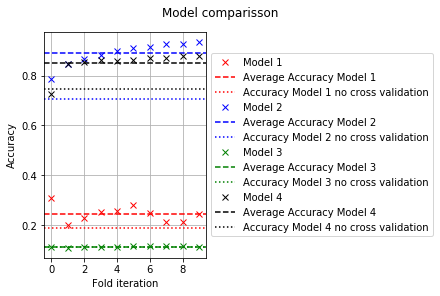

In [50]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

ax1.plot(Fold_accuracy_4,"kx",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='k',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='k',ls=":")

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.44
